# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import (
    load_data,
    show_single_face,
    show_faces,
    partition_data,
    split_left_right,
    join_left_right,
    show_split_faces,
)
import numpy as np
import matplotlib.pyplot as plt
import time  # for timing sgd and gd iterations
from tqdm.notebook import tqdm  # for progress bars when running loops
import warnings  # to suppress warnings for infinities encountered when the loss does not converge

data, labels = load_data()
data = data / 255
# show_single_face(data[0, :])
# show_faces(data[:16, :], num_per_row=4)


## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [3]:
def l2_rls_train(data, labels, regularisation_constant):
    """
    Returns the weights given input data, its labels and the value of
    regularisation constant according to the regularised
    least squares model. If the regularisatioin constant is set
    to zero, finds the weights according to the Moore-Penrose 
    pseudo inverse with np.linalg.pinv.

    data, np.array: the input images to find the weights, each row representing a single image
    labels, np.array: labels of each image
    regularisation_constant, float: the lambda to use in the regularised
    least squares model. Must be greater or equal to zero.

    Returns: 
    weights, np.array: the weights of the LLS found from the data, labels and the method used
    """
#     raise an AssertionError if the weight is smaller than zero
    if regularisation_constant < 0:
        raise AssertionError("Regularisation constant must be greater or equal to 0.")
    X, y = data, labels
#   expand input for the bias multiplication
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
#   choose the weight finding method according to lambda
    if regularisation_constant == 0:
        X_tilde_pinv = np.linalg.pinv(X_tilde)
        weights = X_tilde_pinv @ y
    else:
        weights = (
            (
                np.linalg.inv(
                    X_tilde.T @ X_tilde
                    + regularisation_constant * np.identity(X_tilde.shape[1])
                )
            )
            @ (X_tilde.T)
            @ (y)
        )
    return weights


def predict(weights, data):
    """
    Given the weights and the input data, predicts the
    labels of the data as a linear regression model

    weights, np.array: weights to apply in the model
    data, np.array: the input images to find the weights, each row representing a single image

    Returns: 
    predicted_y, np.array: labels predicted from the weights and the data
    """
#   expand for bias 
    X_tilde = np.hstack((np.ones((data.shape[0], 1)), data))
    predicted_y = X_tilde @ weights
    return predicted_y


In [4]:
def split_and_relabel_dataset(
    full_data, full_labels, original_subject_labels, labels_to_set
):
    """
    Given a dataset, its full labels, labels of the pictures that the 
    user wants to choose, and the labels to replace them with,
    returns a dataset where only the desired samples are left,
    labeled as the user chose

    full_data, np.array: the full dataset to choose the samples from
    full_labels, np.array: the coresponding labels of the full dataset
    original_subject_labels, np.array: the originals labels of the subject that the user wants to choose
    labels_to_set, np.array: the labels that the ones of the desired subject will be replaced with

    Returns: 
    experiment_data, np.array: dataset where only the the desired samples are left
    experiment_labels, np.array: the labels chosen to replace for each sample
    """
    indices_for_original_subject_labels = np.zeros(
        (len(original_subject_labels), 10)
    ).astype(np.int64)
    experiment_labels = np.array([]).astype(np.uint8)
    indices_for_original_subject_labels = np.zeros(
        (len(original_subject_labels), 10)
    ).astype(np.int64)

    for i, subject_label in enumerate(original_subject_labels):
        indices_for_original_subject_labels[i] = np.where(full_labels == subject_label)[
            0
        ]
        if i == 0:
            experiment_data = full_data[indices_for_original_subject_labels[i]]
            experiment_labels = np.array([])
        else:
            experiment_data = np.vstack(
                (experiment_data, full_data[indices_for_original_subject_labels[i]])
            )
        experiment_labels = np.append(
            experiment_labels,
            np.ones(indices_for_original_subject_labels[i].shape) * labels_to_set[i],
        )
    return experiment_data, experiment_labels


def train_test_random_split(experiment_data, experiment_labels, number_per_class_train):
    """
    Randomly splits the dataset and its labels into training and testing dataset
    given the number of samples per class for training. Assumes a balance between
    classes in the dataset.

    experiment_data, np.array: the full dataset to choose the samples from
    experiment_labels, np.array: the coresponding labels of the full dataset
    number_per_class_train, int: number of samples to use for training in each class

    Returns: 
    training_data, np.array: training samples
    training_labels, np.array: labels of training samples
    testing_data, np.array: testing samples
    testing_labels, np.array: labels of testing samples
    """
    training_indices, testing_indices = partition_data(
        experiment_labels, number_per_class_train
    )
    training_data = experiment_data[training_indices, :]
    training_labels = experiment_labels[training_indices]
    testing_data = experiment_data[testing_indices, :]
    testing_labels = experiment_labels[testing_indices]
    return training_data, training_labels, testing_data, testing_labels


def binary_threshold(predictions_not_thresholded, y_1, y_2):
    """
    Applies a binary threshold to values predicted by a model,
    given the values of y_1 and y_2. The threshold is automatically
    chosen as the average of y_1 and y_2.

    predictions_not_thresholded, np.array: unthresholded predicted labels of the model
    y_1, float: the value to set for the predictions below the threshold
    y_1, float: the value to set for the predictions above the threshold

    Returns: 
    training_data, np.array: training samples
    """
    threshold = (y_1 + y_2) / 2
    found_labels = np.empty(np.shape(predictions_not_thresholded))
    found_labels[np.where(predictions_not_thresholded < threshold)] = y_1
    found_labels[np.where(predictions_not_thresholded >= threshold)] = y_2
    return found_labels


def find_accuracy(predictions, ground_truth):
    """
    Finds the accuracy of predictions compared to GT.

    predictions, np.array: thresholded predicted labels of the model
    ground_truth, np.array: true labels to compare

    Returns: 
    accuracy, float: accuracy of the predictions
    """
    return np.count_nonzero(predictions == ground_truth) / len(ground_truth)


def exp_1(
    full_data,
    full_labels,
    original_subject_labels,
    labels_to_set,
    number_per_class_train,
    y_1,
    y_2,
    regularisation_constant,
    iterations,
):
    """
    Finds the train and test accuracies of the method with test and train
    dataset randomisation in each of the iterations
    the full dataset, its labels, the original subject labels to choose from
    labels to replace them with, number of training samples per class,

    
    the regularisation constant to use in RLS, and 
    

    full_data, np.array: the full dataset of samples
    full_labels, np.array: labels for the full dataset
    original_subject_labels: the original subject labels to choose from
    labels_to_set, np.array: labels to replace them with
    number_per_class_train, int: number of training samples per class
    y_1, float: the value to replace the unthresholded value below the threshold for predictions
    y_2, float: the value to replace the unthresholded value above the threshold for predictions
    regularisation_constant, float: the regularisation constant to use in RLS
    iterations, int: the number of iterations to 
    record the fluctuations given the randomisation of the dataset
    
    Returns: 
    training_accuracies, np.array: accuracy of the training among iterations
    testing_accuracies, np.array: accuracy of the testing among iterations
    
    """
    
    experiment_data, experiment_labels = split_and_relabel_dataset(
        full_data, full_labels, original_subject_labels, labels_to_set
    )
    training_accuracies, testing_accuracies = np.array([]), np.array([])
    for i in tqdm(np.arange(0, iterations, 1)):
        (
            training_data,
            training_labels,
            testing_data,
            testing_labels,
        ) = train_test_random_split(
            experiment_data, experiment_labels, number_per_class_train
        )
        weights = l2_rls_train(training_data, training_labels, regularisation_constant)

        training_predictions_not_thresholded = predict(weights, training_data)
        found_training_labels = binary_threshold(
            training_predictions_not_thresholded, y_1, y_2
        )
        training_accuracy = find_accuracy(found_training_labels, training_labels)
        training_accuracies = np.append(training_accuracies, training_accuracy)

        testing_predictions_not_thresholded = predict(weights, testing_data)
        found_testing_labels = binary_threshold(
            testing_predictions_not_thresholded, y_1, y_2
        )
        testing_accuracy = find_accuracy(found_testing_labels, testing_labels)
        testing_accuracies = np.append(testing_accuracies, testing_accuracy)
    return training_accuracies, testing_accuracies


#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [5]:
# classifier 1: y_1 = -1, y_2 = 1; threshold = 0 (set automatically as the average)

ITERATIONS = 5000

train_accuracies_1, test_accuracies_1 = exp_1(
    full_data=data,
    full_labels=labels,
    original_subject_labels=np.array([1, 30]),
    labels_to_set=np.array([-1, 1]),
    number_per_class_train=3,
    y_1=-1,
    y_2=1,
    regularisation_constant=0,
    iterations=ITERATIONS,
)


  0%|          | 0/5000 [00:00<?, ?it/s]

Repeat the same experiment for classifier 2.

In [6]:
# classifier 2: y_1 = 0, y_2 = 1; threshold = 0.5 (set automatically as the average)
train_accuracies_2, test_accuracies_2 = exp_1(
    full_data=data,
    full_labels=labels,
    original_subject_labels=np.array([1, 30]),
    labels_to_set=np.array([0, 1]),
    number_per_class_train=3,
    y_1=0,
    y_2=1,
    regularisation_constant=0,
    iterations=ITERATIONS,
)


  0%|          | 0/5000 [00:00<?, ?it/s]

Repeat the same experiment for classifier 3.

In [7]:
# classifier 3: y_1 = 1, y_2 = 30; threshold = 15.5 (set automatically as the average)
train_accuracies_3, test_accuracies_3 = exp_1(
    full_data=data,
    full_labels=labels,
    original_subject_labels=np.array([1, 30]),
    labels_to_set=np.array([1, 30]),
    number_per_class_train=3,
    y_1=1,
    y_2=30,
    regularisation_constant=0,
    iterations=ITERATIONS,
)


  0%|          | 0/5000 [00:00<?, ?it/s]

Print out the mean and the std values of the test errors of the three classifiers.

In [8]:
print("With ", str(ITERATIONS), " randomised trials:")

print(
    "For classifier 1 (y_1=-1; y_2=1; thr.=0): testing error={0:.4f}±{1:.4f}".format(
        1 - np.mean(test_accuracies_1),
        np.std(test_accuracies_1),
    )
)

print(
    "For classifier 2 (y_1=0; y_2=1; thr.=0.5): testing error={0:.4f}±{1:.4f}".format(
        1 - np.mean(test_accuracies_2),
        np.std(test_accuracies_2),
    )
)

print(
    "For classifier 3 (y_1=1; y_2=30; thr.=15.5): testing error={0:.4f}±{1:.4f}".format(
        1 - np.mean(test_accuracies_3),
        np.std(test_accuracies_3),
    )
)


With  5000  randomised trials:
For classifier 1 (y_1=-1; y_2=1; thr.=0): testing error=0.0669±0.0879
For classifier 2 (y_1=0; y_2=1; thr.=0.5): testing error=0.0717±0.0921
For classifier 3 (y_1=1; y_2=30; thr.=15.5): testing error=0.0756±0.0921


#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [9]:
# left, right = split_left_right(data)
# show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [10]:
train, _, test, _ = train_test_random_split(
    experiment_data=data, experiment_labels=labels, number_per_class_train=4
)

train_left, train_right = split_left_right(train)
test_left, test_right = split_left_right(test)

weights = l2_rls_train(train_left, train_right, 0)

output_train = predict(weights, train_left)
output_test = predict(weights, test_left)

MAPE_train = np.mean(np.abs((train_right - output_train) / train_right))
MAPE_test = np.mean(np.abs((test_right - output_test) / test_right))

print("Training MAPE={0:.15f}".format(MAPE_train))
print("Testing MAPE={0:.4f}".format(MAPE_test))


Training MAPE=0.000000000000005
Testing MAPE=0.2204


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

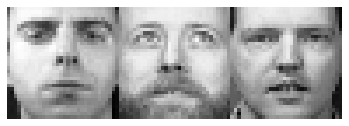

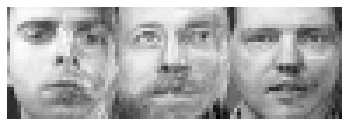

In [11]:
indices = np.random.randint(0, output_test.shape[0], 3)
fake_faces = join_left_right(test_left, output_test)
true_faces = join_left_right(test_left, test_right)
show_faces(true_faces[indices, :], num_per_row=3)
show_faces(fake_faces[indices, :], num_per_row=3)


#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [12]:
def lls_gd_train(data, labels, learning_rate, N):
    """
    Returns the weights given input data, its labels, the learning rate,
    and the number of iterations according to gradient descent algorithm. 

    data, np.array: the input images to find the weights, each row representing a single image
    labels, np.array: labels of each image
    learning_rate, float: the learning rate to use in the gradient descent alg.
    N, int: number of iterations to implement GD

    Returns: 
    w_all, np.array: the weights recorded for each iteration of GD
    cost_all, np.array: the cost values recorded for each iteration of GD
    times_all, np.array: the time that each iteration took
    """

    X, y = data, labels
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
#     initialise the weights as zeros
    w = np.zeros((X_tilde.shape[1]))
#     we're keeping track of costs, weight values, and times of all iterations
    cost_all = np.array([])
    w_all = np.empty((N + 1, w.size))
    w_all[0] = w
    times_all = np.array([])
    for i in tqdm(range(N)):
#         note time when the iteration started
        t_0 = time.time()
#     calculate the gradient
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
#     calculate the cost with the linalg.norm
        cost = 0.5 * np.linalg.norm(X_tilde @ w - y)  # ** 2
#     update the weights
        w = w - learning_rate * gd
        cost_all = np.append(cost_all, cost)
        w_all[i + 1] = w
#         note time when the iteration ended
        t_1 = time.time()
        times_all = np.append(times_all, (t_1 - t_0))
    return w_all, cost_all, times_all


def find_f1_macro(found_labels, ground_truth):
    """
    Given predicted labels and the ground truth labels,
    calculates the macro averaged F1 score for all
    classes.
    
    I tested some stuff with but ultimately don't use it because 
    we don't have inbalance among the classes, so it basically follows
    the accuracy.    
    """
    f1_scores = np.array([])
    for index in np.unique(ground_truth):
        true_positives, false_positives, false_negatives, true_negatives = 0, 0, 0, 0
        true_positives += np.count_nonzero(
            np.in1d(
                (np.where(found_labels == index)[0]),
                (np.where(ground_truth == index)[0]),
            )
        )
        false_positives += np.count_nonzero(
            np.in1d(
                (np.where(found_labels == index)[0]),
                (np.where(ground_truth != index)[0]),
            )
        )
        false_negatives += np.count_nonzero(
            np.in1d(
                (np.where(found_labels != index)[0]),
                (np.where(ground_truth == index)[0]),
            )
        )
        true_negatives += np.count_nonzero(
            np.in1d(
                (np.where(found_labels != index)[0]),
                (np.where(ground_truth != index)[0]),
            )
        )
        if (true_positives + false_positives) == 0:
            precision = 0
        else:
            precision = true_positives / (true_positives + false_positives)
        if (true_positives + false_negatives) == 0:
            recall = 0
        else:
            recall = true_positives / (true_positives + false_negatives)
        if (precision + recall) == 0:
            f1_score = 0
        else:
            f1_score = 2 * precision * recall / (precision + recall)
        f1_scores = np.append(f1_scores, f1_score)
    return np.mean(f1_scores)


def convergence_approach_test(cost_all):
    """
     Tests whether the recorded cost values among GD and SGD 
     iterations ultimately decrease. The first condition is that
     the values of the abs. mean negative gradient of the cost
     multiplied by the amount of them is larger than the positive
     analogous. The second was that the amount of negative
     gradients is larger than the positive ones, but I had 
     problems with SGD with lr=0.006 when it obviously
     was converging, so ultimately left only the first condition,
     which seems to do the job. It is analogous to testing
     whether a larger distance has been travelled down from the start.

    cost_all, np.array: recorded cost values for each GD/SGD iter.
    
    Returns: 
    converging, bool: whether the cost value is converging or not
    """
#     suppress the varning due to nans or inftys
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
#         calculate the gradient of the cost
        cost_gradients = np.gradient(cost_all)
#       names are explanatory
        indices_of_negative_gradient_points = np.where(cost_gradients < 0)
        negative_cost_gradients = cost_gradients[indices_of_negative_gradient_points]
        num_negative_cost_gradients = len(negative_cost_gradients)
        mean_negative_gradient = num_negative_cost_gradients * np.mean(
            negative_cost_gradients
        )

        indices_of_positive_gradient_points = np.where(cost_gradients >= 0)
        positive_cost_gradients = cost_gradients[indices_of_positive_gradient_points]
        num_positive_cost_gradients = len(positive_cost_gradients)
        if num_positive_cost_gradients == 0:
            mean_positive_gradient = 0
        else:
            mean_positive_gradient = num_positive_cost_gradients * np.mean(
                positive_cost_gradients
            )
        decreases_most_of_the_time = (
            num_negative_cost_gradients > num_positive_cost_gradients
        )
        decreases_faster_than_increases = (
            np.abs(mean_negative_gradient) > mean_positive_gradient
        )
        converging = decreases_faster_than_increases #& decreases_most_of_the_time
    return converging


def from_recorded_weights_to_accuracy_array(data, labels, w_all, y_1, y_2, N):
    """
    Means of finding the accuracy array from the recorded weights
    given either the training or testing data.

    w_all, np.array: recorded weights from the training iterations
    
    ... same stuff as before
    
    Returns: 
    accuracy_array, np.array: accuracy from each weight row
    """
    accuracy_array = np.array([])
    for i in range(N):
        predictions = predict(w_all[i], data)
        thresholded_predictions = binary_threshold(predictions, y_1, y_2)
        accuracy = find_accuracy(thresholded_predictions, labels)
        accuracy_array = np.append(accuracy_array, accuracy)
    return accuracy_array


def plot_results(
    algorithm,
    convergence,
    cost_values,
    training_accuracies,
    testing_accuracies,
    iteration_times,
    learning_rate,
    N,
):
    
    """
    Plots the results of the measurement with the used algorithm and
    the convergence test result (in the title!). Plots the cost decreasing
    among iterations, the test and train valuse among iterations, and
    the timings of each iteration along with the mean as a red line.

    algorithm, str: Type of algorithm to use in the title
    convergence, bool: whether the cost values converge or not according to the test
    
    ...same stuff as before
    
    
    Returns: 
    None
    """
    mean_iteration_time = np.mean(iteration_times)
    plotting_range = np.arange(0, N, 1)

    if convergence:
        convergence_string = "converging"
    else:
        convergence_string = "diverging"
    fig = plt.figure(figsize=(16, 12), dpi=200)
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(323)
    ax3 = plt.subplot(324)
    ax4 = plt.subplot(414)
    ax1.plot(plotting_range, cost_values)
    ax2.plot(plotting_range, training_accuracies)
    ax3.plot(plotting_range, testing_accuracies)
    ax4.plot(plotting_range, iteration_times)
    ax4.axhline(
        y=mean_iteration_time,
        xmin=0,
        xmax=N,
        c="red",
        label=r"$t_{mean}$=" + str(np.round(mean_iteration_time, decimals=5)),
    )

    ax1.set_title(
        algorithm
        + r", Loss vs epochs, $\eta=$"
        + str(learning_rate)
        + r", $N=$"
        + str(N)
        + ", "
        + convergence_string
    )
    ax1.set_xlabel(r"Epoch number")
    ax1.set_ylabel(r"Loss")

    ax2.set_title(r"Training accuracy")
    ax2.set_xlabel(r"Epoch number")
    ax2.set_ylabel(r"Training accuracy")

    ax3.set_title(r"Testing accuracy")
    ax3.set_xlabel(r"Epoch number")
    ax3.set_ylabel(r"Testing accuracy")

    ax4.set_title(r"Time of a single training iteration")
    ax4.set_xlabel(r"Epoch number")
    ax4.set_ylabel(r"Time, s")
    ax4.legend(loc="best")

    
def find_index_of_last_change(accuracies_array):
    accuracies_gradient = np.gradient(accuracies_array)
    last_change_index = np.where(accuracies_gradient != 0)[0][-1]
    return last_change_index

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

  0%|          | 0/200 [00:00<?, ?it/s]

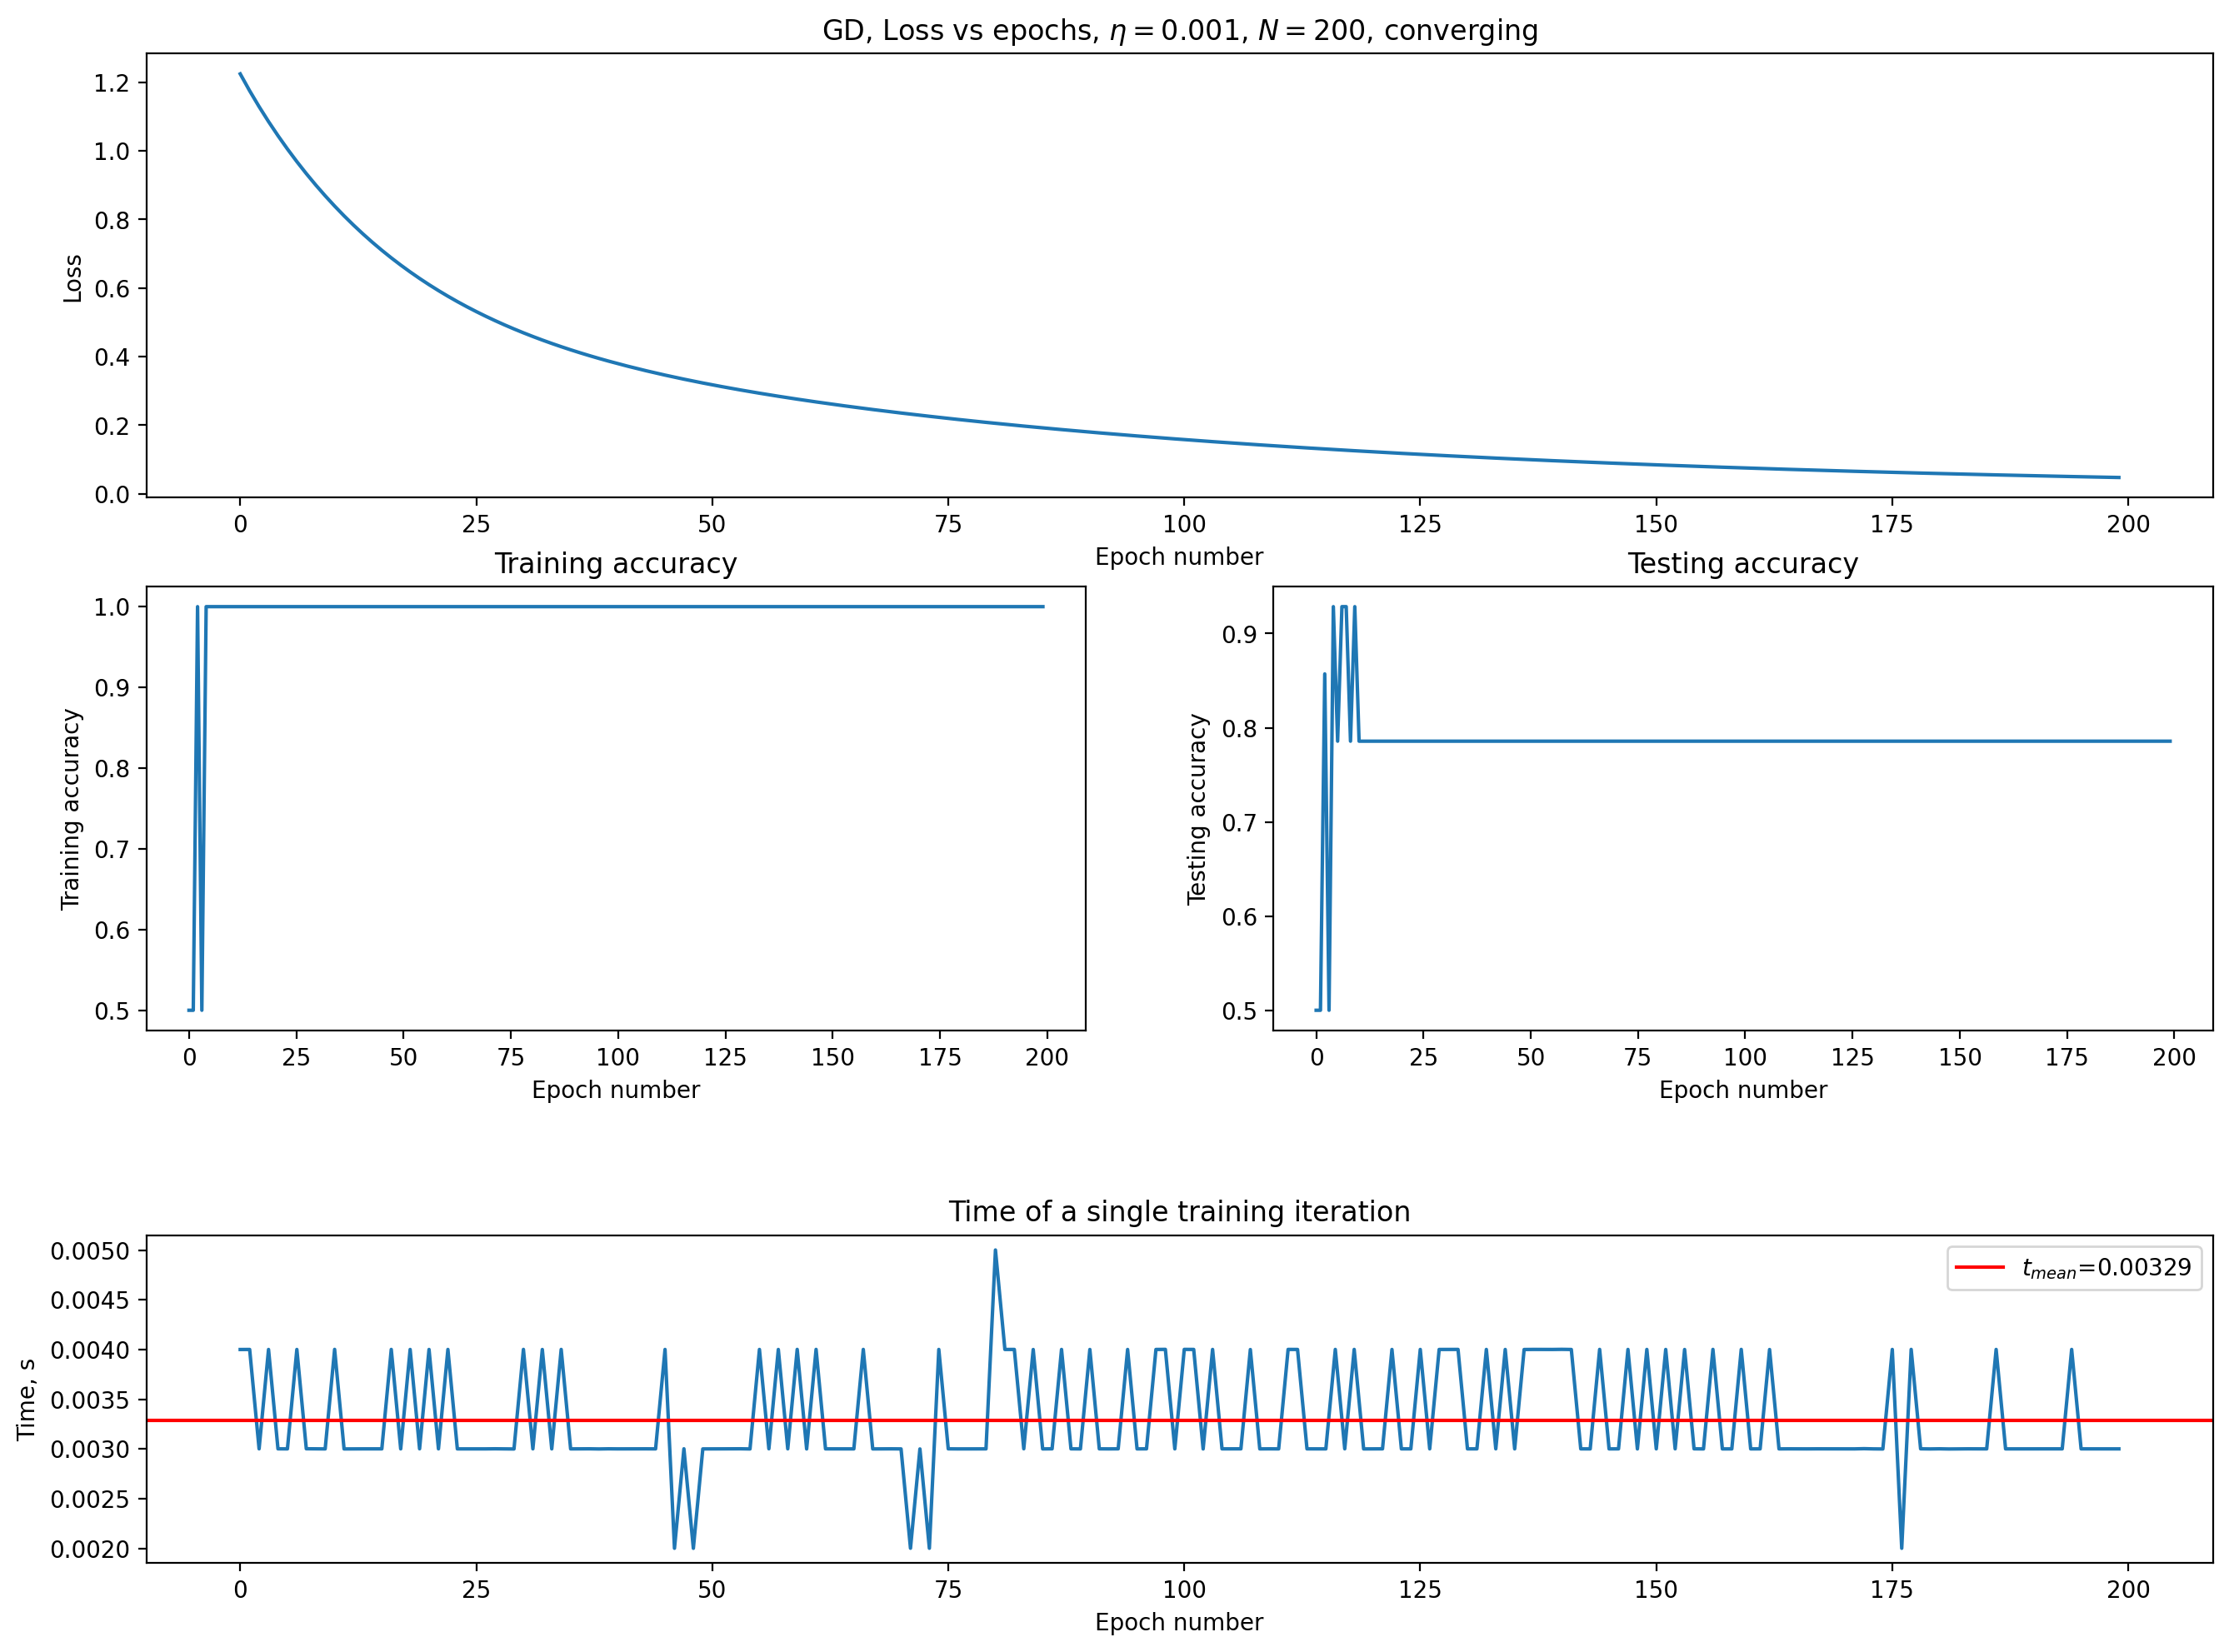

In [13]:
LEARNING_RATE = 10**-3
ITERATIONS = 200
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1
gd_data, gd_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=np.array([-1, 1]),
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=gd_data, experiment_labels=gd_labels, number_per_class_train=3
)
recorded_weights, recorded_cost_values, recorded_iteration_times = lls_gd_train(
    train, train_labels, LEARNING_RATE, ITERATIONS
)
converging_or_not = convergence_approach_test(recorded_cost_values)
train_accuracies = from_recorded_weights_to_accuracy_array(
    train, train_labels, recorded_weights, Y_1, Y_2, ITERATIONS
)
test_accuracies = from_recorded_weights_to_accuracy_array(
    test, test_labels, recorded_weights, Y_1, Y_2, ITERATIONS
)

plot_results(
    "GD",
    converging_or_not,
    recorded_cost_values,
    train_accuracies,
    test_accuracies,
    recorded_iteration_times,
    LEARNING_RATE,
    ITERATIONS,
)




Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

  0%|          | 0/200 [00:00<?, ?it/s]

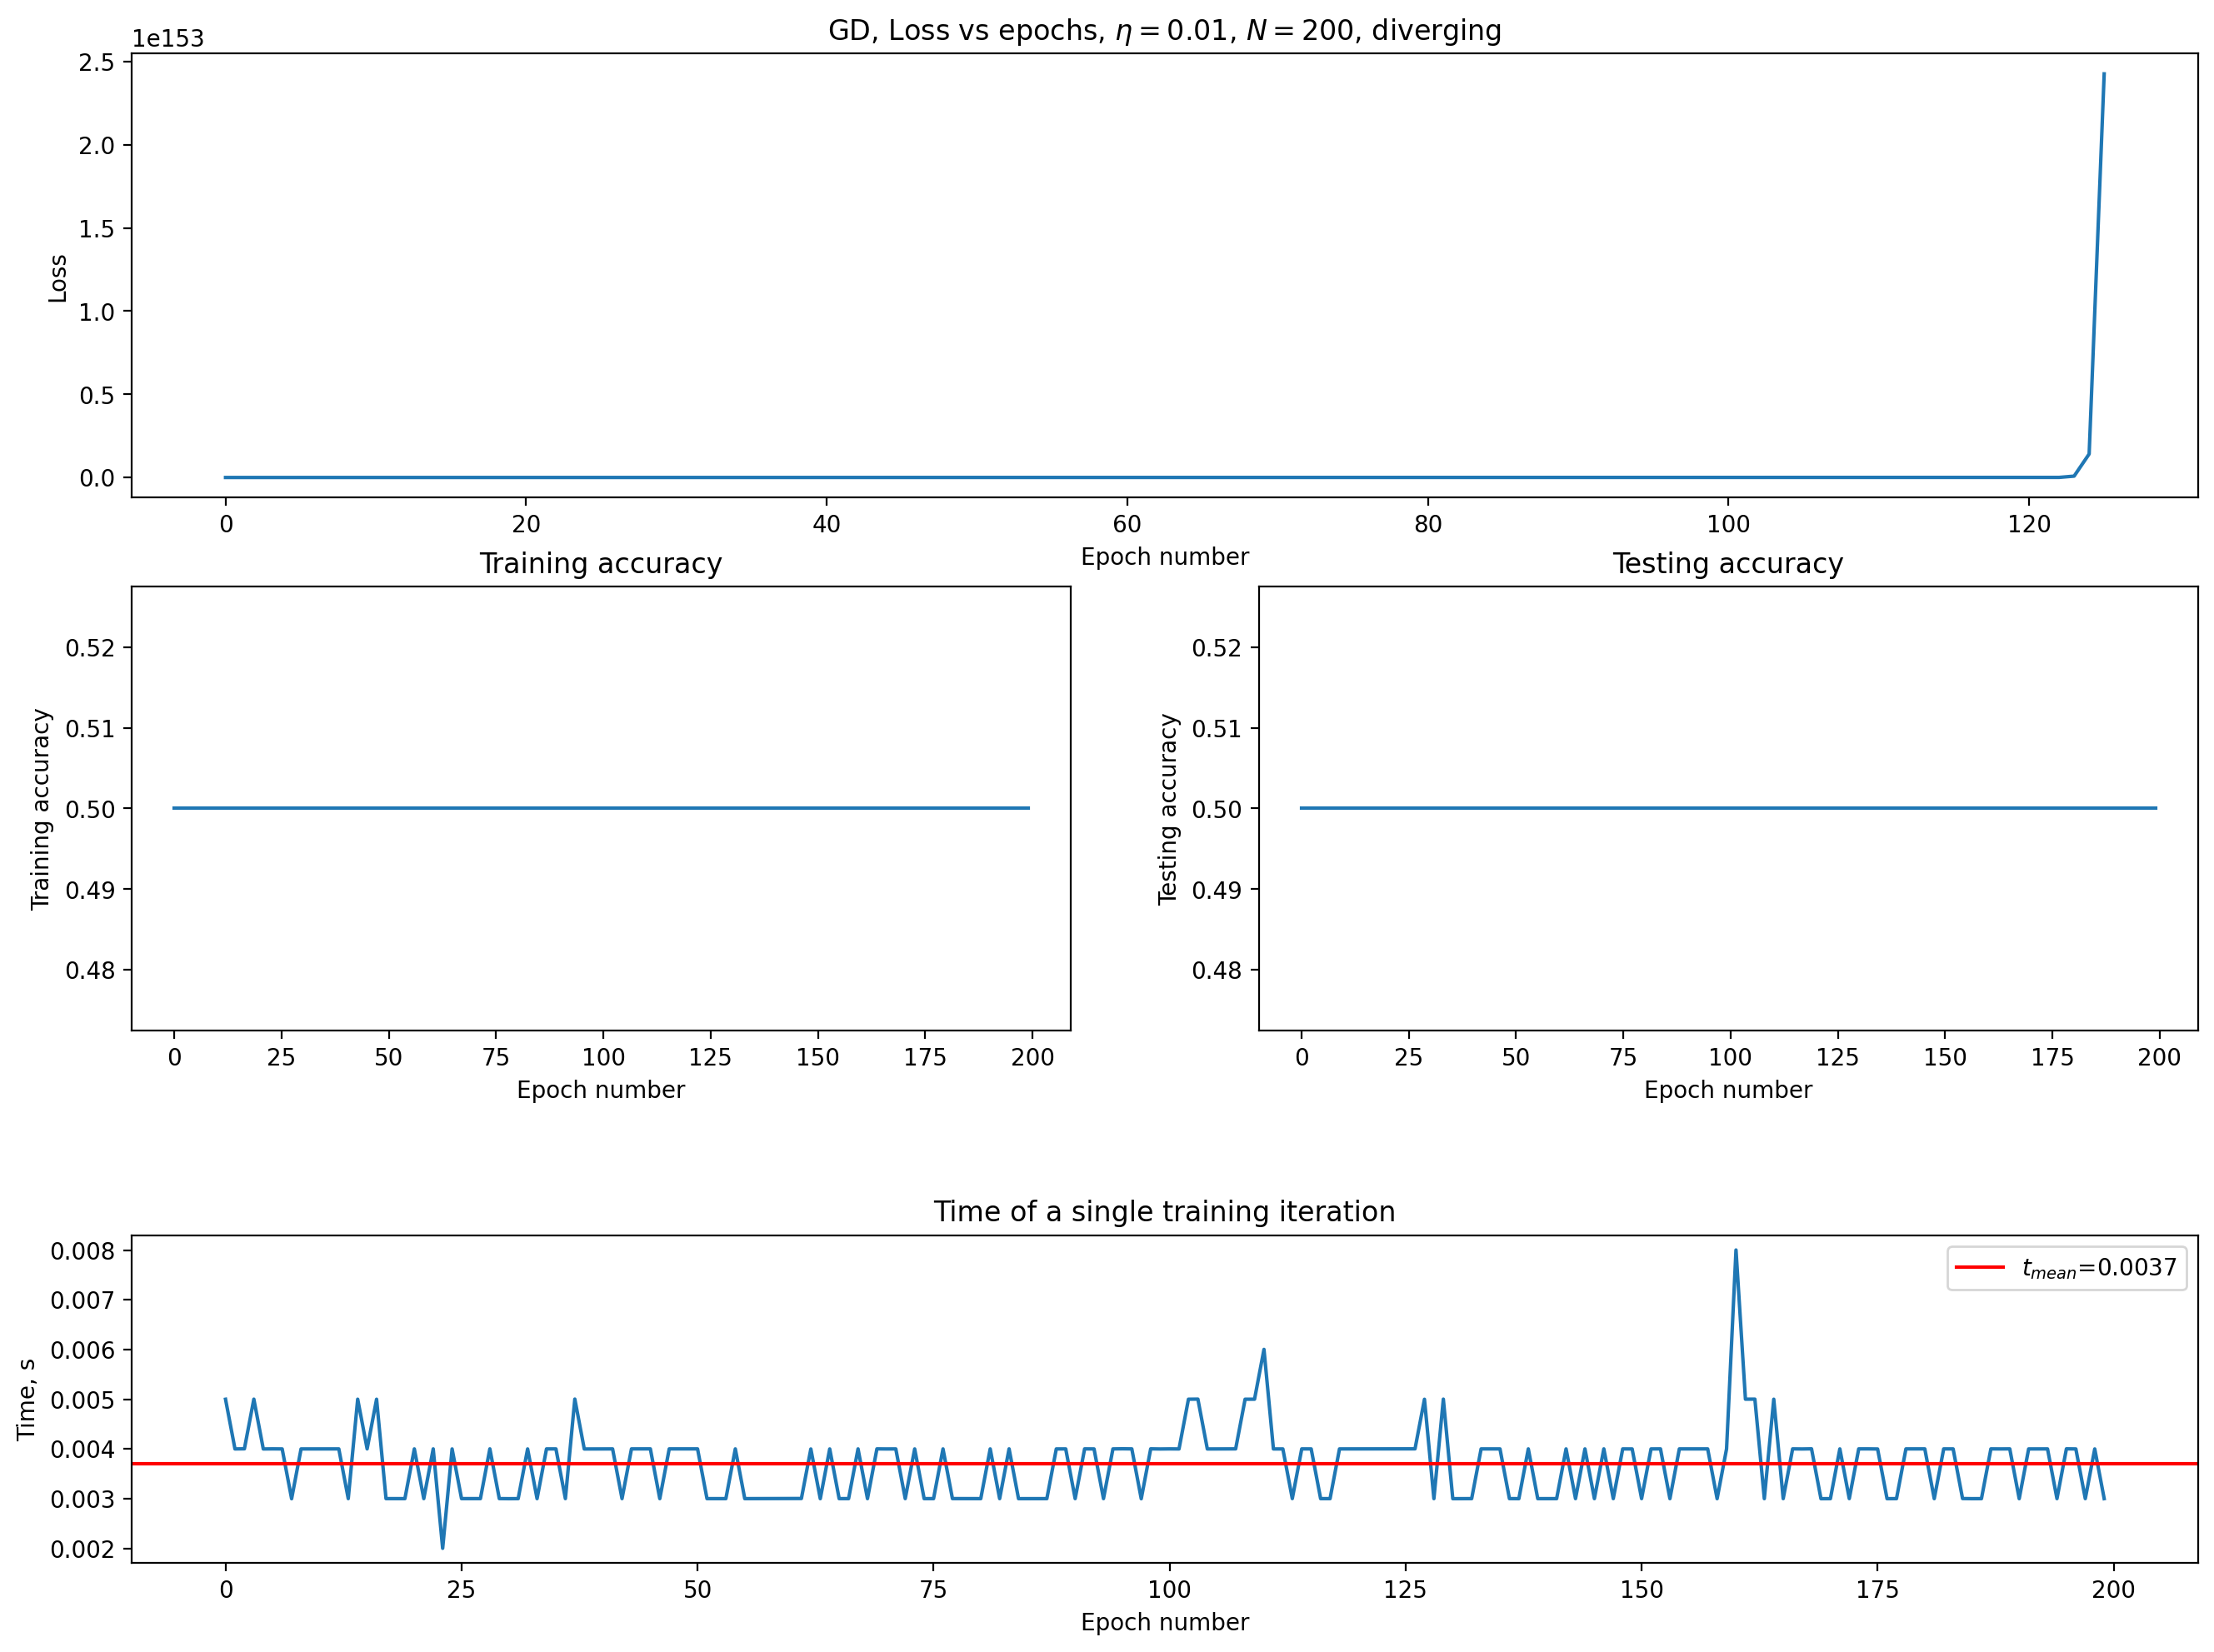

In [14]:
LEARNING_RATE = 10**-2
ITERATIONS = 200
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1
gd_data, gd_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=np.array([-1, 1]),
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=gd_data, experiment_labels=gd_labels, number_per_class_train=3
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recorded_weights, recorded_cost_values, recorded_iteration_times = lls_gd_train(
        train, train_labels, LEARNING_RATE, ITERATIONS
    )
    converging_or_not = convergence_approach_test(recorded_cost_values)
    train_accuracies = from_recorded_weights_to_accuracy_array(
        train, train_labels, recorded_weights, Y_1, Y_2, ITERATIONS
    )
    test_accuracies = from_recorded_weights_to_accuracy_array(
        test, test_labels, recorded_weights, Y_1, Y_2, ITERATIONS
    )
plot_results(
    "GD",
    converging_or_not,
    recorded_cost_values,
    train_accuracies,
    test_accuracies,
    recorded_iteration_times,
    LEARNING_RATE,
    ITERATIONS,
)


#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [15]:
def lls_sgd_train(data, labels, learning_rate, N):
    """
    Returns the weights given input data, its labels, the learning rate,
    and the number of iterations according to stochastic gradient descent algorithm. 
    Same as GD, only calculates the gradient according to ONE sample

    data, np.array: the input images to find the weights, each row representing a single image
    labels, np.array: labels of each image
    learning_rate, float: the learning rate to use in the gradient descent alg.
    N, int: number of iterations to implement GD

    Returns: 
    w_all, np.array: the weights recorded for each iteration of GD
    cost_all, np.array: the cost values recorded for each iteration of GD
    times_all, np.array: the time that each iteration took
    """

    X, y = data, labels
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    w = np.zeros((X_tilde.shape[1]))
    cost_all = np.array([])
    w_all = np.empty((N + 1, w.size))
    w_all[0] = w
    times_all = np.array([])
    for i in tqdm(range(N)):
        t_0 = time.time()
#         choose the index of the random sample and its label; resize it to be usable
        index = np.random.randint(0, y.size)
        X_rand = (X_tilde[index]).reshape(1, X_tilde.shape[1])
        y_rand = (y[index]).reshape(1)
        gd = X_rand.T @ X_rand @ w - X_rand.T @ y_rand
#         cost = 0.5 * np.linalg.norm(X_rand @ w - y_rand)  # ** 2
        cost = 0.5 * np.linalg.norm(X_tilde @ w - y) # ** 2
        w = w - learning_rate * gd
        cost_all = np.append(cost_all, cost)
        w_all[i + 1] = w
        t_1 = time.time()
        times_all = np.append(times_all, (t_1 - t_0))
    return w_all, cost_all, times_all


### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


#### Checking SGD learning rate boundaries for LR hyperparameter grid search (from 1e-3 to 1e-2)
We repeat the same experiments for SGD with the same learning rates, just with a larger number of iterations, to see whether we consider the current convergence and divergence limits for the grid search (two steps below) the same as for GD. Obviously, we need a larger number of epochs, because the number of samples that we are using to calculate the gradient is only one of six. Hence, for estimation, in an ideal scenario we would need the number of iterations at least six times as large as for, but due to the stochastic nature of randomly picking  the index, we multiply the number of iterations by more, for example, seven.

  0%|          | 0/1400 [00:00<?, ?it/s]

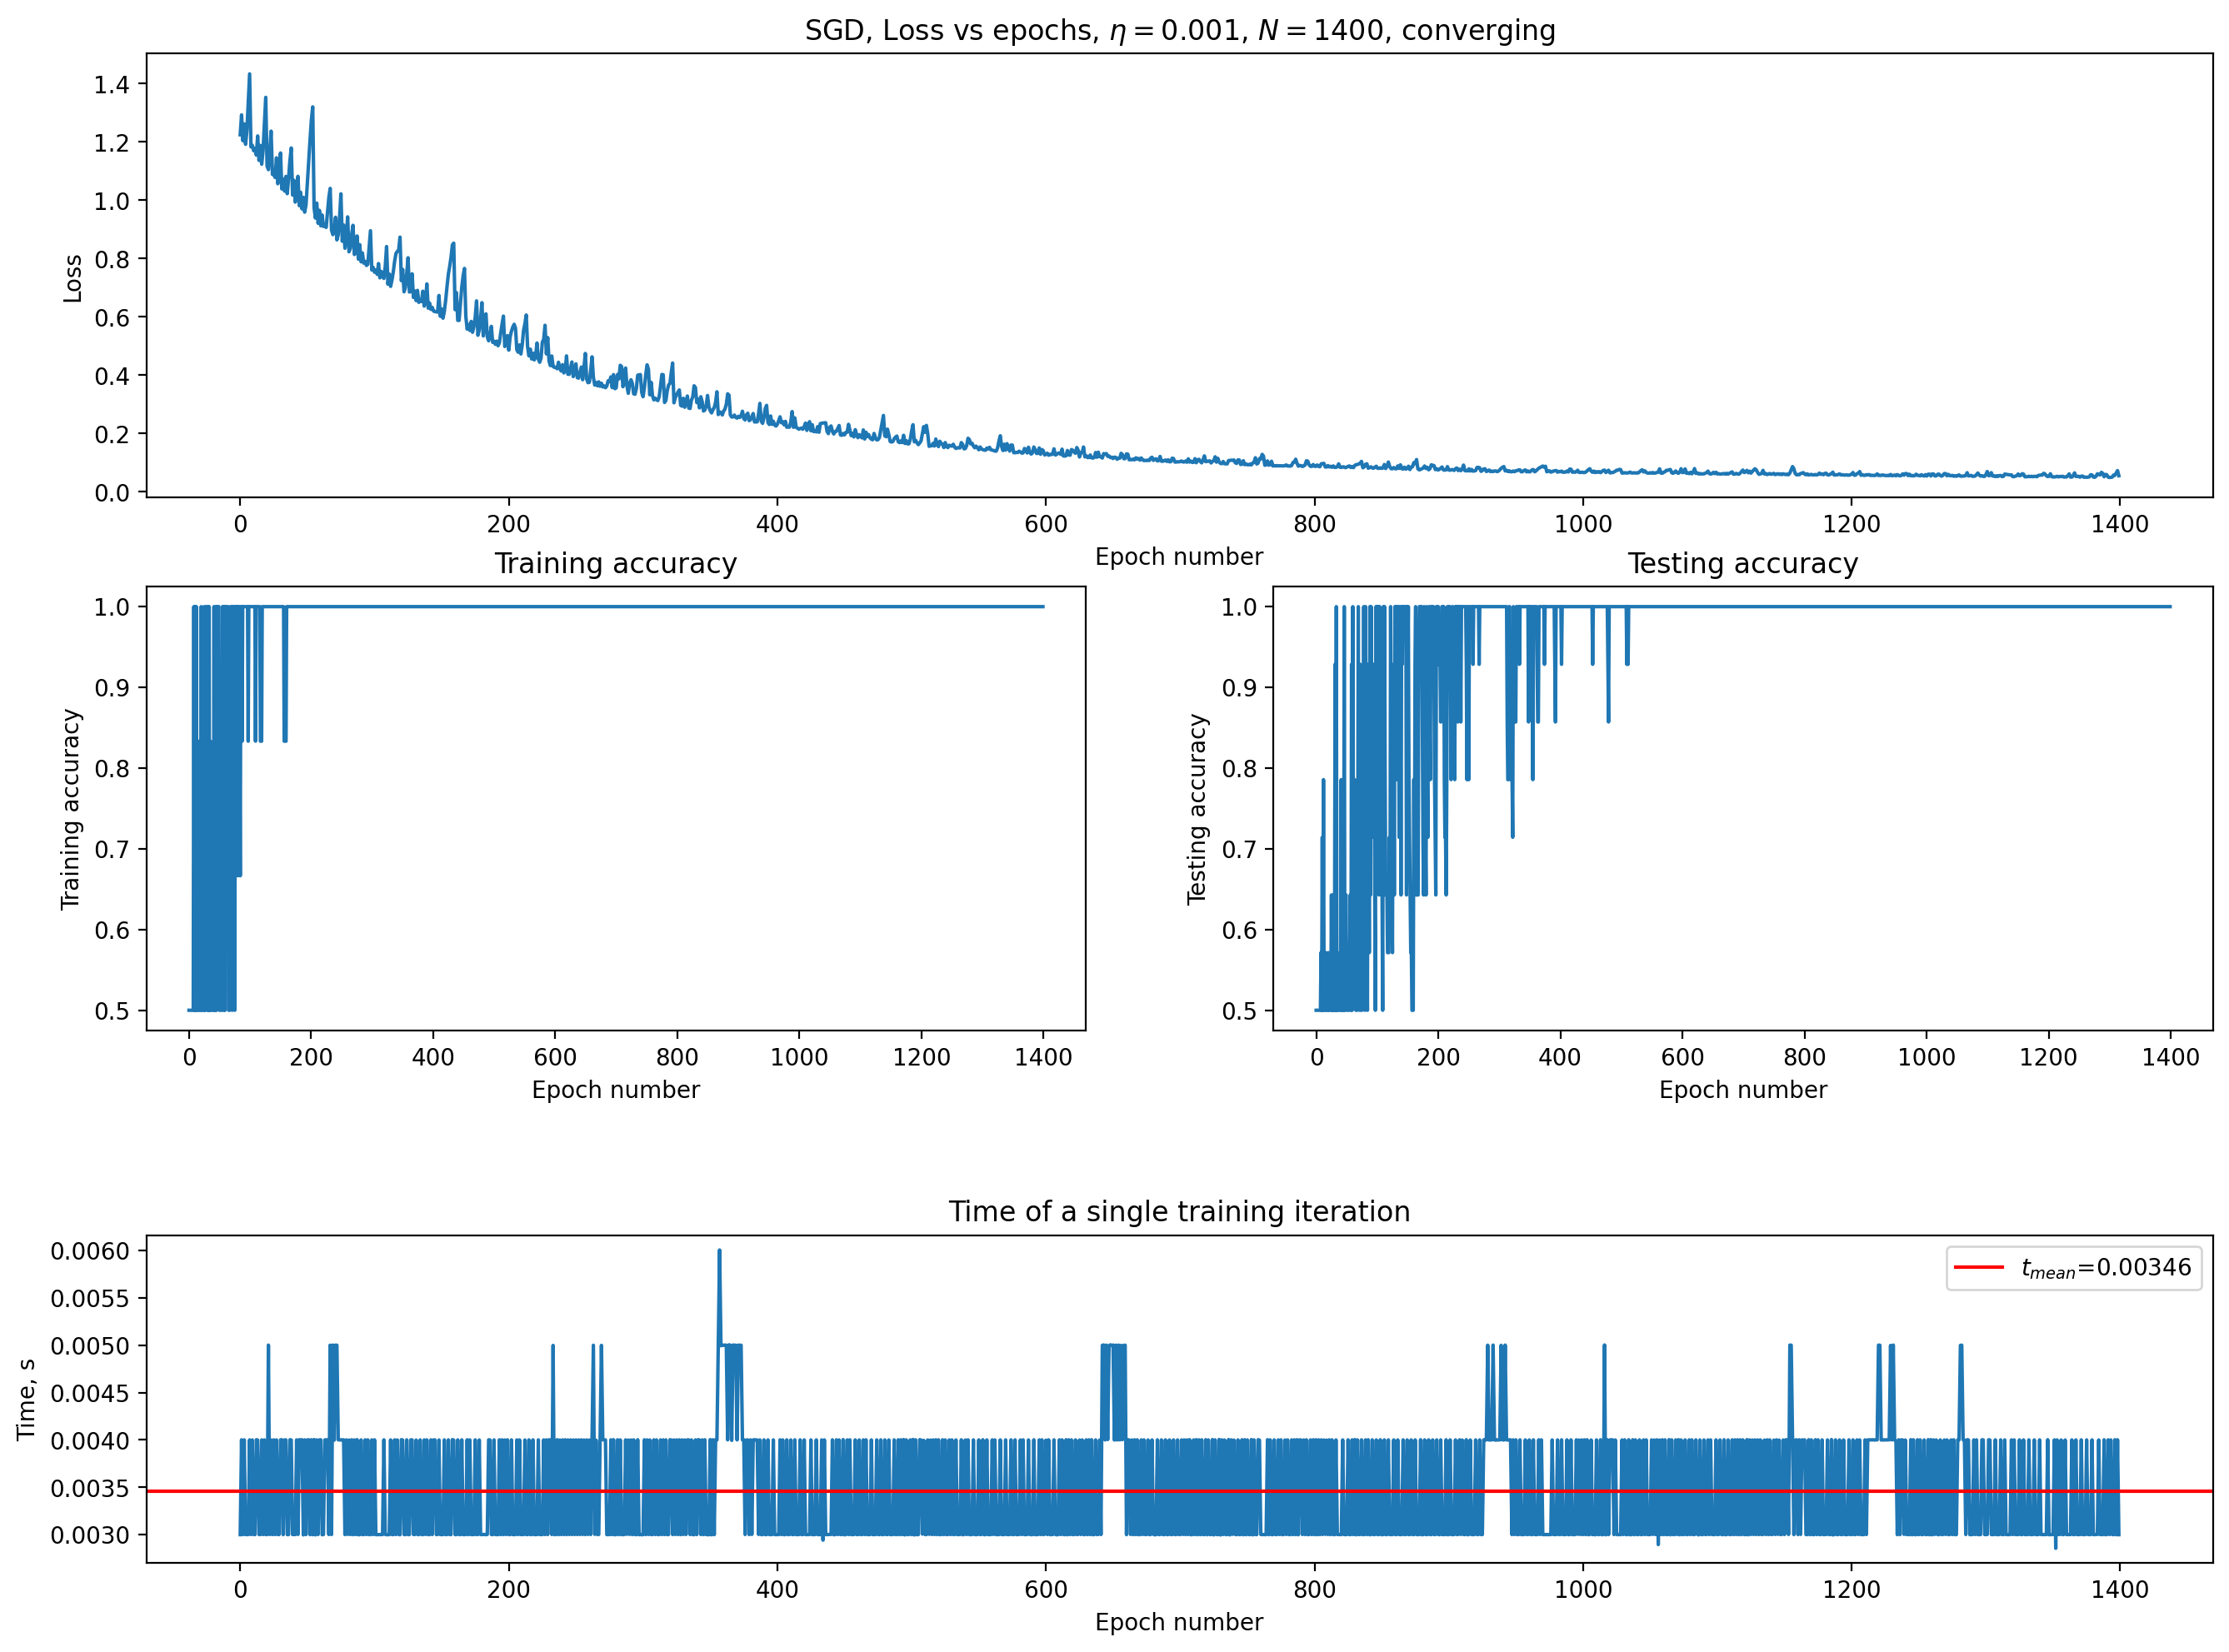

In [16]:
LEARNING_RATE = 10**-3
ITERATIONS = 1400
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1
gd_data, gd_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=np.array([-1, 1]),
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=gd_data, experiment_labels=gd_labels, number_per_class_train=3
)
recorded_weights, recorded_cost_values, recorded_iteration_times = lls_sgd_train(
    train, train_labels, LEARNING_RATE, ITERATIONS
)
converging_or_not = convergence_approach_test(recorded_cost_values)
train_accuracies = from_recorded_weights_to_accuracy_array(
    train, train_labels, recorded_weights, Y_1, Y_2, ITERATIONS
)
test_accuracies = from_recorded_weights_to_accuracy_array(
    test, test_labels, recorded_weights, Y_1, Y_2, ITERATIONS
)
plot_results(
    "SGD",
    converging_or_not,
    recorded_cost_values,
    train_accuracies,
    test_accuracies,
    recorded_iteration_times,
    LEARNING_RATE,
    ITERATIONS,
)


  0%|          | 0/1400 [00:00<?, ?it/s]

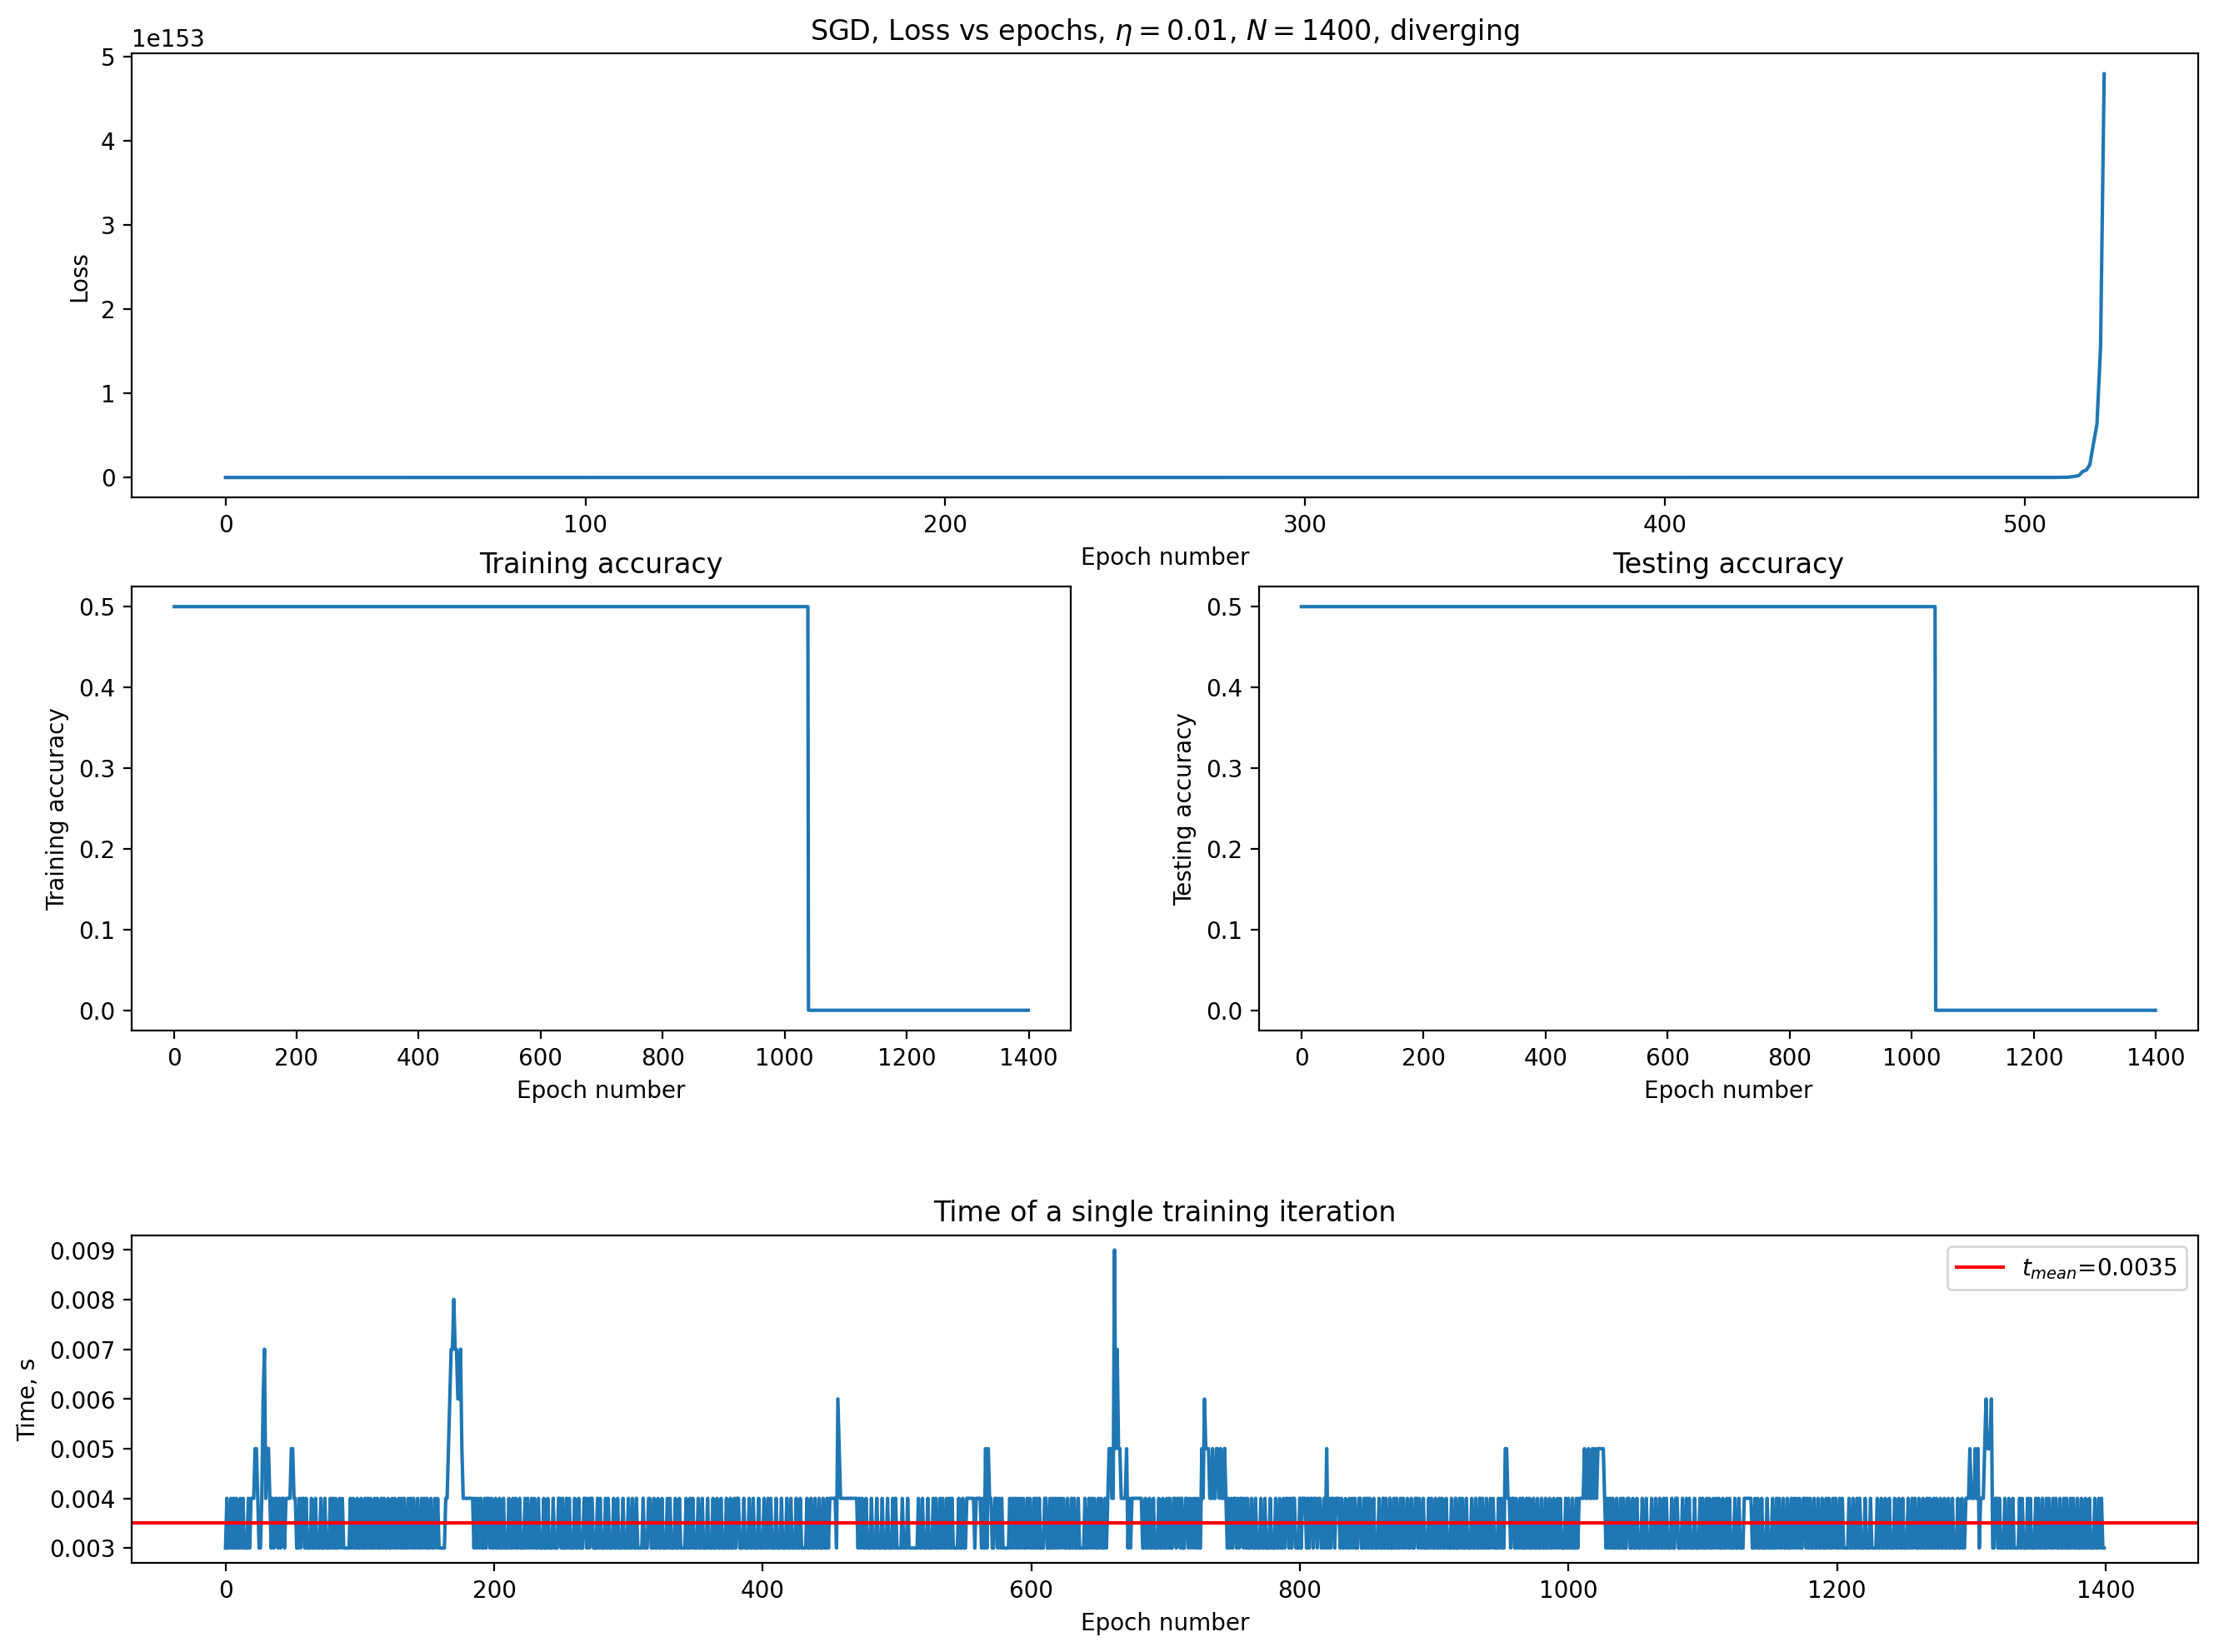

In [17]:
LEARNING_RATE = 10**-2
ITERATIONS = 1400
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1
gd_data, gd_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=np.array([-1, 1]),
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=gd_data, experiment_labels=gd_labels, number_per_class_train=3
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recorded_weights, recorded_cost_values, recorded_iteration_times = lls_sgd_train(
        train, train_labels, LEARNING_RATE, ITERATIONS
    )
    converging_or_not = convergence_approach_test(recorded_cost_values)
    train_accuracies = from_recorded_weights_to_accuracy_array(
        train, train_labels, recorded_weights, Y_1, Y_2, ITERATIONS
    )
    test_accuracies = from_recorded_weights_to_accuracy_array(
        test, test_labels, recorded_weights, Y_1, Y_2, ITERATIONS
    )
    plot_results(
        "SGD",
        converging_or_not,
        recorded_cost_values,
        train_accuracies,
        test_accuracies,
        recorded_iteration_times,
        LEARNING_RATE,
        ITERATIONS,
    )


We find that the search always blows up on η=1e-2 and converges for η=1e-3, hence we'll use the same upper and lower bound for the gridsearch. We can also plot how the SGD and GD losses evolve at some number of epochs, for now, not taking into account the time that each iteration for each algorithm takes.

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

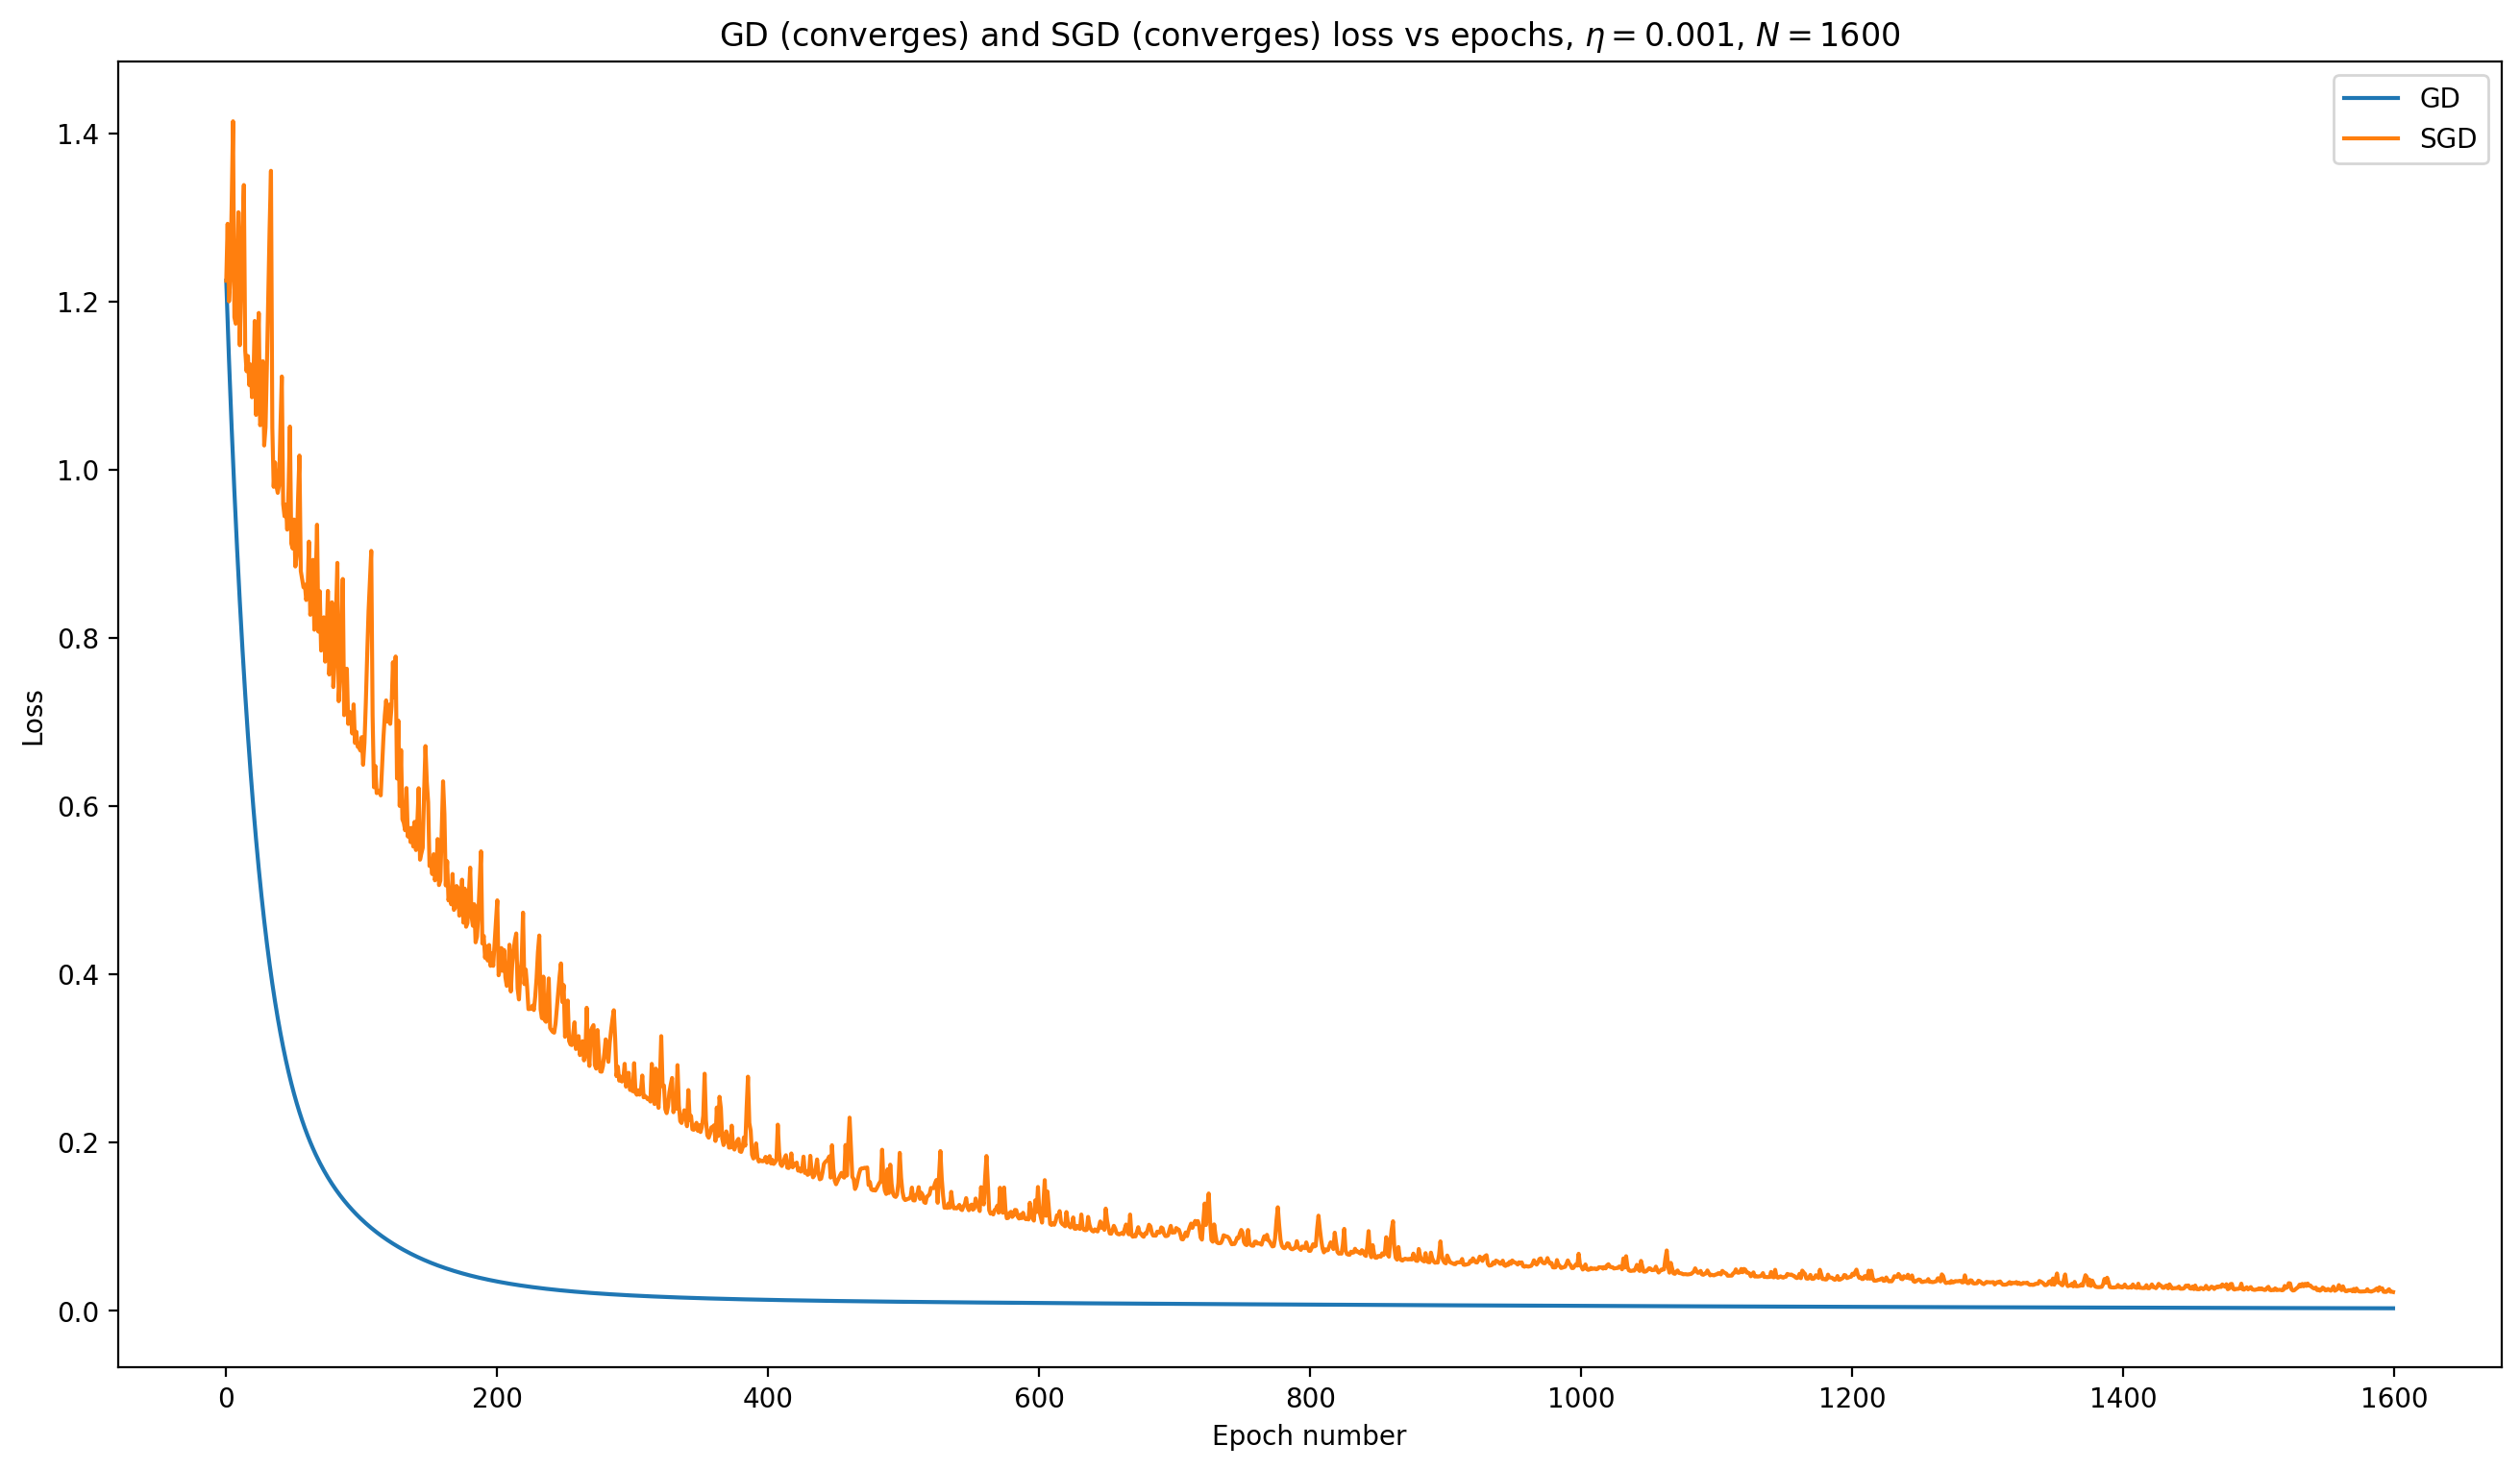

In [18]:
LEARNING_RATE = 10**-3
ITERATIONS = 1600
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1
exp_data, exp_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=np.array([-1, 1]),
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=exp_data, experiment_labels=exp_labels, number_per_class_train=3
)
(
    recorded_gd_weights,
    recorded_gd_cost_values,
    recorded_gd_iteration_times,
) = lls_gd_train(train, train_labels, LEARNING_RATE, ITERATIONS)
(
    recorded_sgd_weights,
    recorded_sgd_cost_values,
    recorded_sgd_iteration_times,
) = lls_sgd_train(train, train_labels, LEARNING_RATE, ITERATIONS)

gd_converging_bool = convergence_approach_test(recorded_gd_cost_values)
sgd_converging_bool = convergence_approach_test(recorded_sgd_cost_values)

if gd_converging_bool: gd_converging_str="converges"
else: gd_converging_str="diverges"
if sgd_converging_bool: sgd_converging_str="converges"
else: sgd_converging_str="diverges"

fig = plt.figure(figsize=(16, 9), dpi=200)
ax1 = plt.subplot(111)
ax1.plot(np.arange(0, ITERATIONS, 1), recorded_gd_cost_values, label="GD")
ax1.plot(np.arange(0, ITERATIONS, 1), recorded_sgd_cost_values, label="SGD")

ax1.set_title(
    "GD ("
    + gd_converging_str
    +") and SGD ("
    + sgd_converging_str
    + r") loss vs epochs, $\eta=$"
    + str(LEARNING_RATE)
    + r", $N=$"
    + str(ITERATIONS)
)
ax1.set_xlabel(r"Epoch number")
ax1.set_ylabel(r"Loss")
ax1.legend(loc="best")

### Looking for a faster rate for both GD and SGD
Grid check for optimal learning rate between 10 linearly spaced options between the ones that we saw converging (10e-3) and exploding (10e-2) for both GD and SGD without changing the dataset:

In [19]:
exp_data, exp_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=np.array([-1, 1]),
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=exp_data, experiment_labels=exp_labels, number_per_class_train=3
)

  0%|          | 0/1000 [00:00<?, ?it/s]

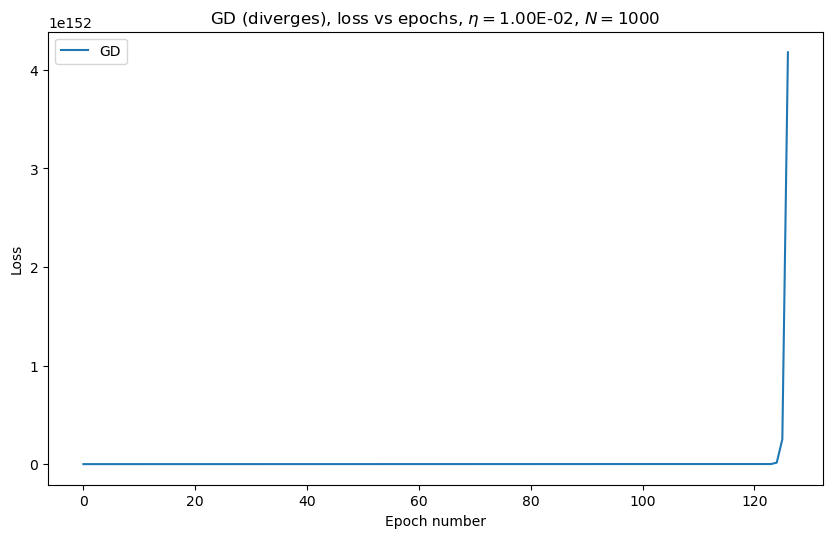

  0%|          | 0/1000 [00:00<?, ?it/s]

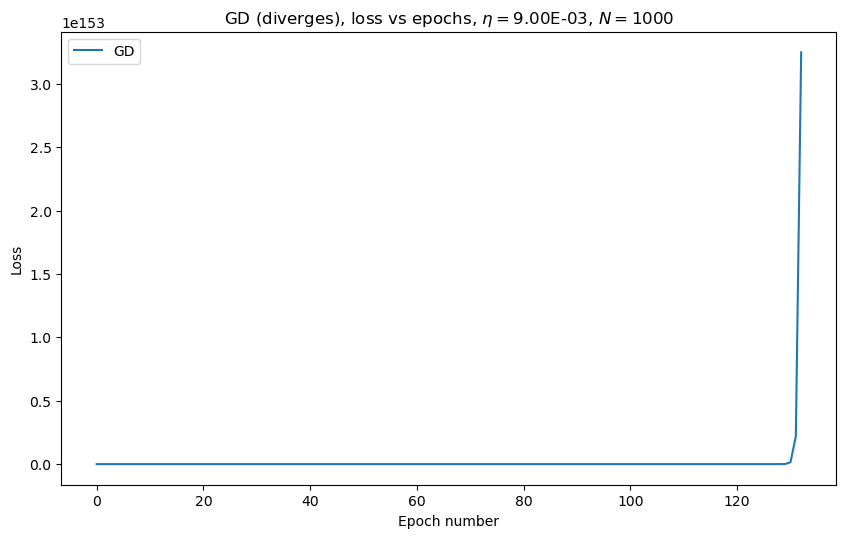

  0%|          | 0/1000 [00:00<?, ?it/s]

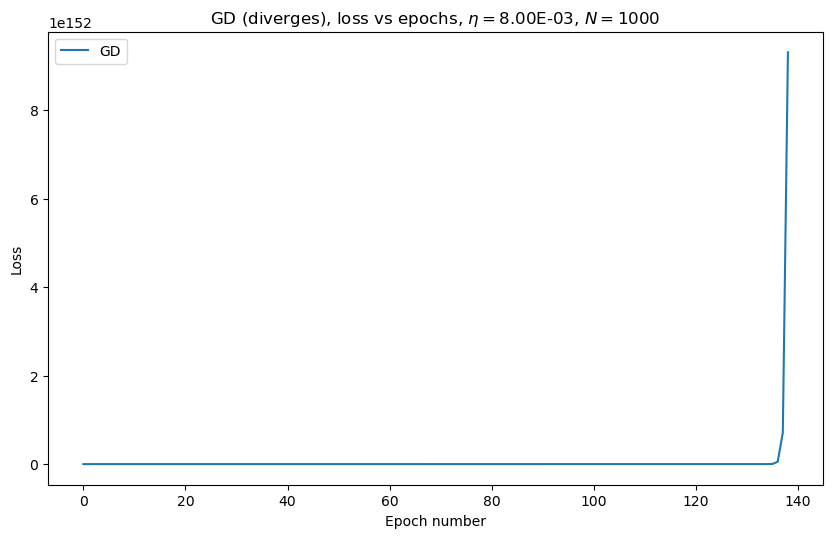

  0%|          | 0/1000 [00:00<?, ?it/s]

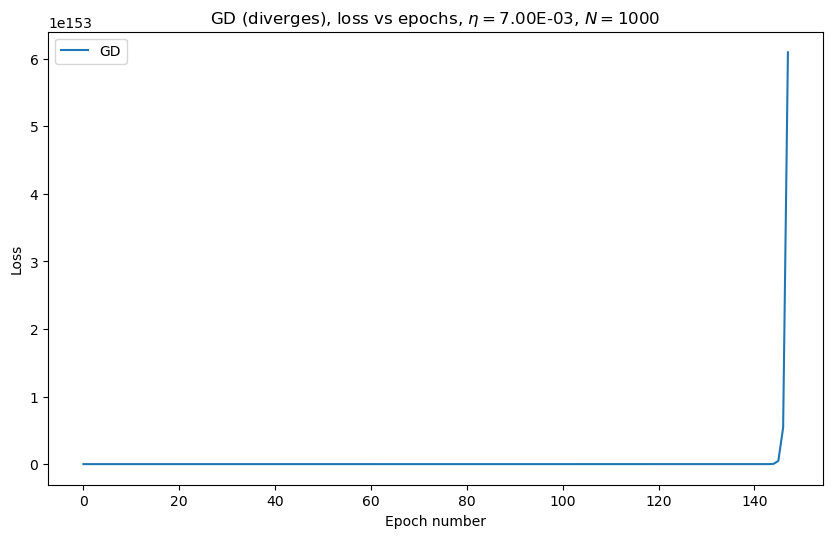

  0%|          | 0/1000 [00:00<?, ?it/s]

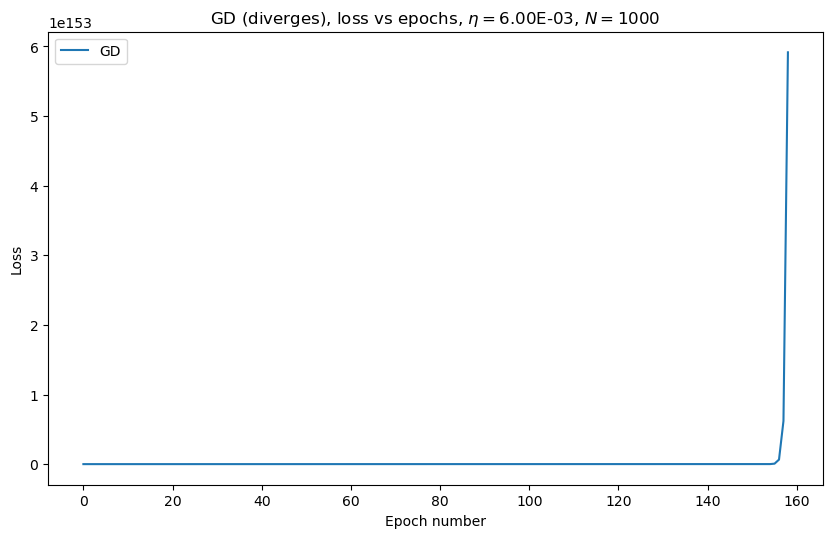

  0%|          | 0/1000 [00:00<?, ?it/s]

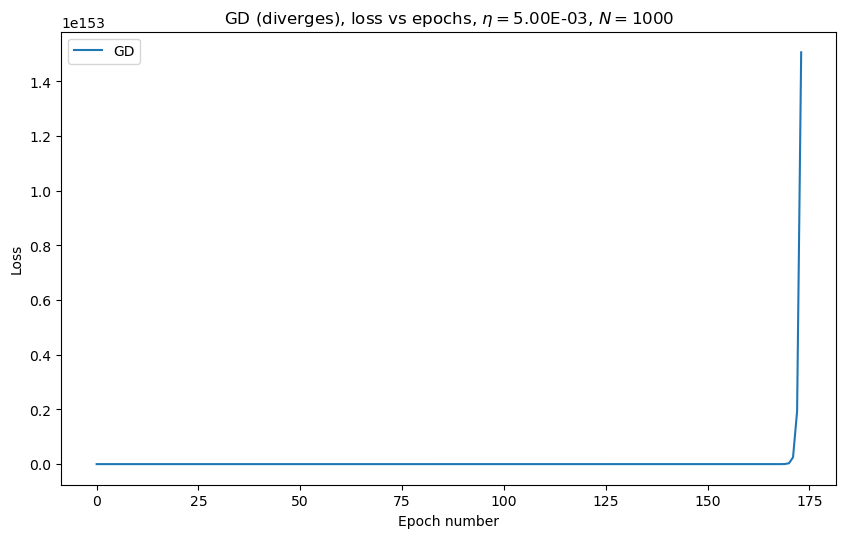

  0%|          | 0/1000 [00:00<?, ?it/s]

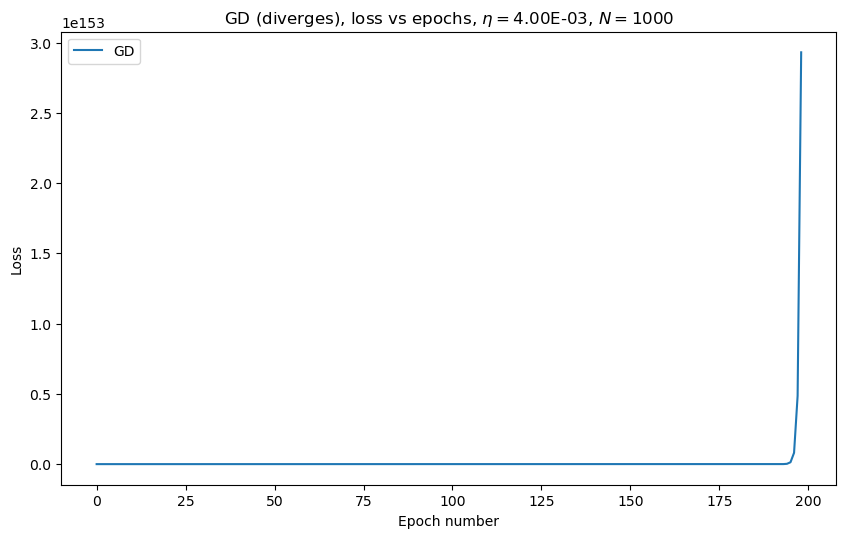

  0%|          | 0/1000 [00:00<?, ?it/s]

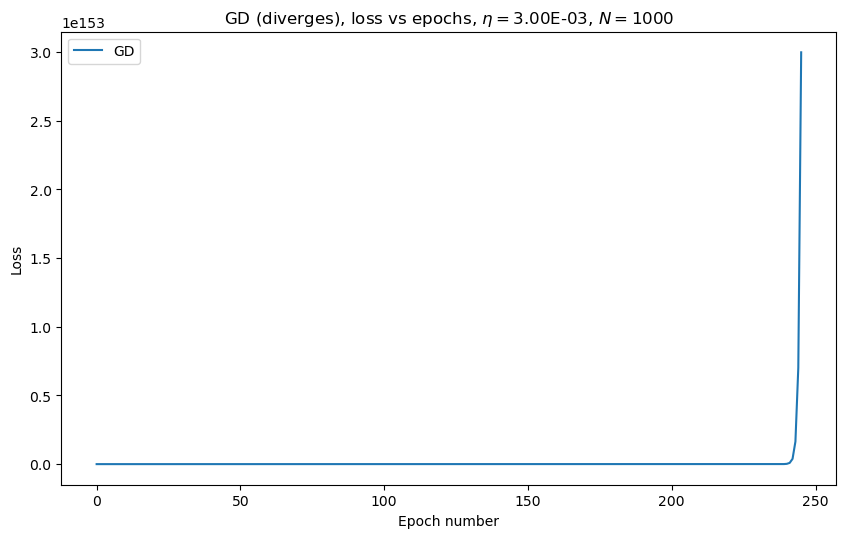

  0%|          | 0/1000 [00:00<?, ?it/s]

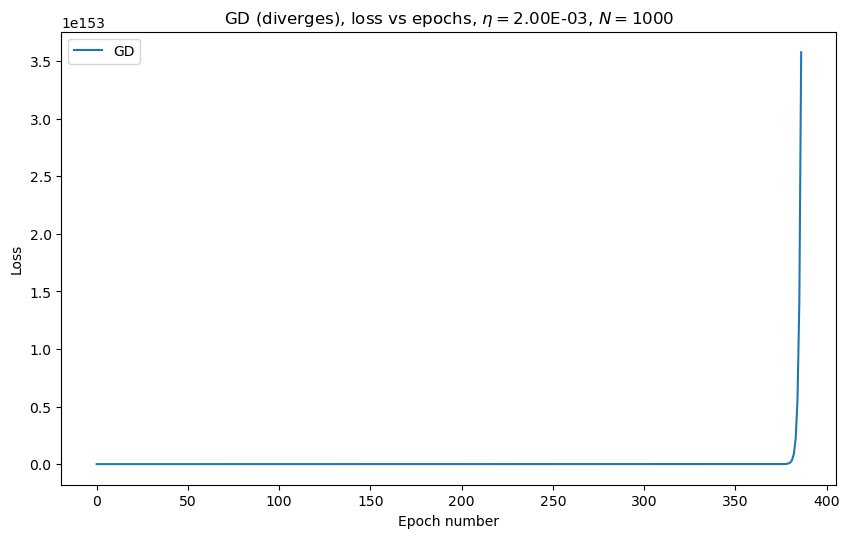

  0%|          | 0/1000 [00:00<?, ?it/s]

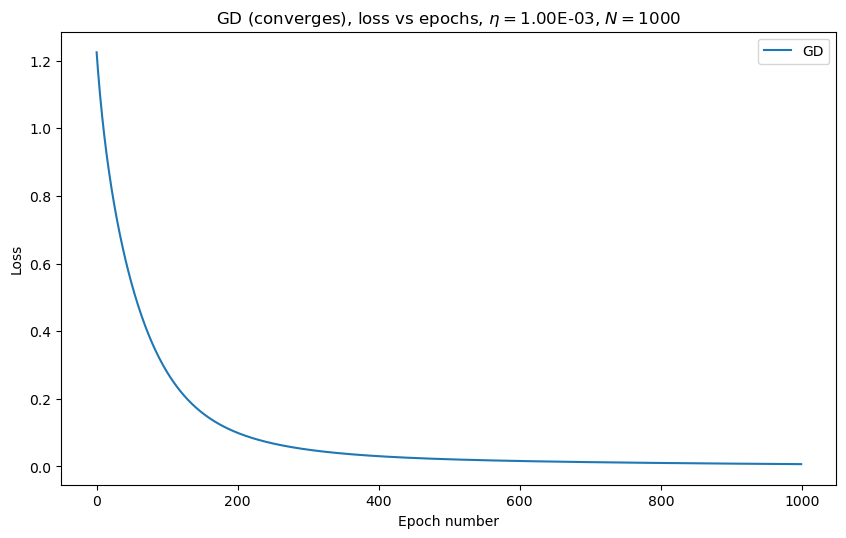

In [20]:
# SGD LR grid check

learning_rates_array = np.linspace(
    10**-2, 10**-3, 10
)  # np.geomspace(10**-3, 10**-2, num=10)
ITERATIONS = 1000
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1

converging_learning_rates_gd = np.array([])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, LEARNING_RATE in enumerate(learning_rates_array):
        (
            recorded_gd_weights,
            recorded_gd_cost_values,
            recorded_gd_iteration_times,
        ) = lls_gd_train(train, train_labels, LEARNING_RATE, ITERATIONS)

        gd_converging_bool = convergence_approach_test(recorded_gd_cost_values)

        if gd_converging_bool:
            gd_converging_str = "converges"
            converging_learning_rates_gd = np.append(
                converging_learning_rates_gd, LEARNING_RATE
            )
        else:
            gd_converging_str = "diverges"

        fig = plt.figure(figsize=(10, 6), dpi=100)
        ax1 = plt.subplot(111)
        ax1.plot(np.arange(0, ITERATIONS, 1), recorded_gd_cost_values, label="GD")

        ax1.set_title(
            "GD ("
            + gd_converging_str
            + r"), loss vs epochs, $\eta=$"
            + "{:.2E}".format(LEARNING_RATE)
            + r", $N=$"
            + str(ITERATIONS)
        )
        ax1.set_xlabel(r"Epoch number")
        ax1.set_ylabel(r"Loss")
        ax1.legend(loc="best")
        plt.show()
FASTEST_LEARNING_RATE_GD = np.min(converging_learning_rates_gd)



  0%|          | 0/3000 [00:00<?, ?it/s]

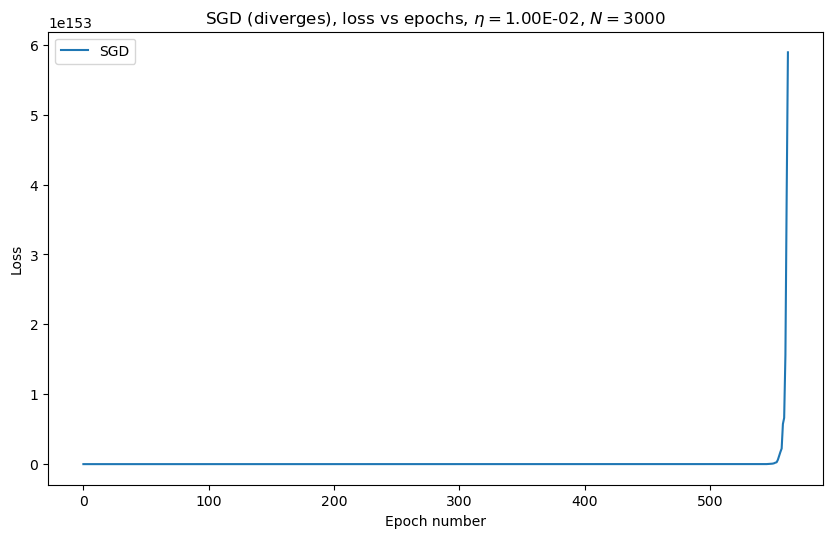

  0%|          | 0/3000 [00:00<?, ?it/s]

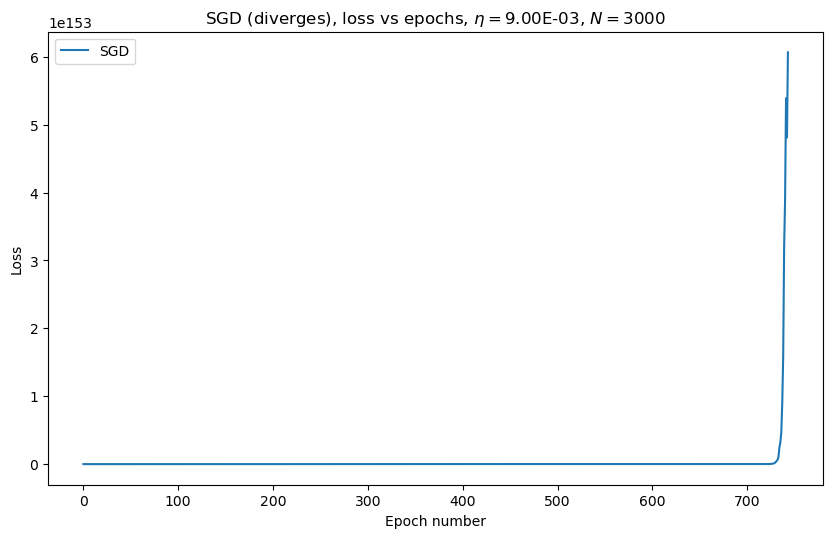

  0%|          | 0/3000 [00:00<?, ?it/s]

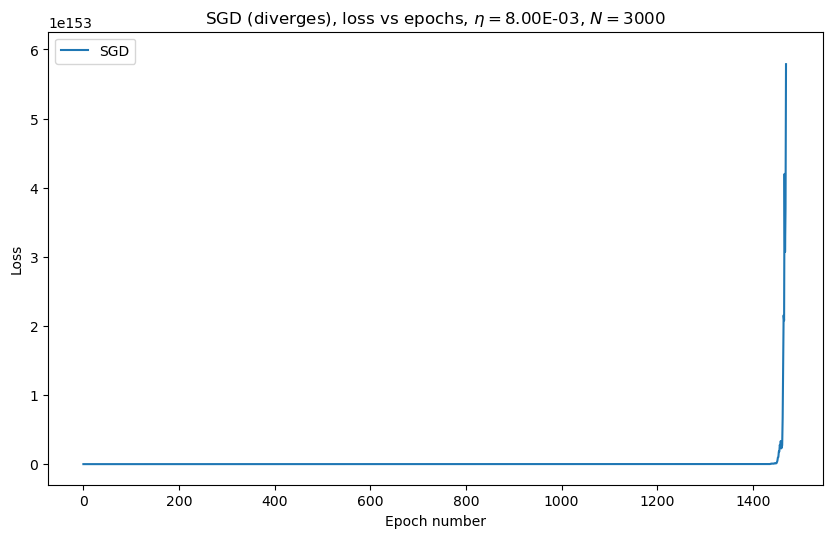

  0%|          | 0/3000 [00:00<?, ?it/s]

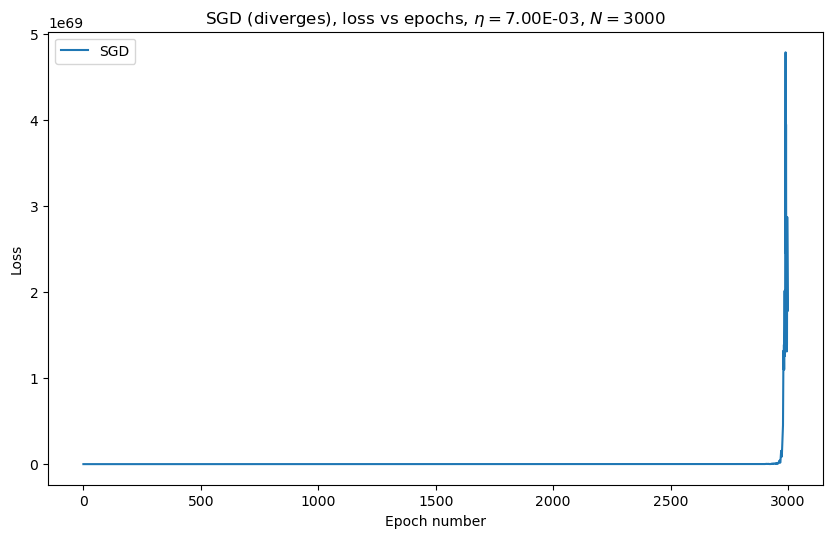

  0%|          | 0/3000 [00:00<?, ?it/s]

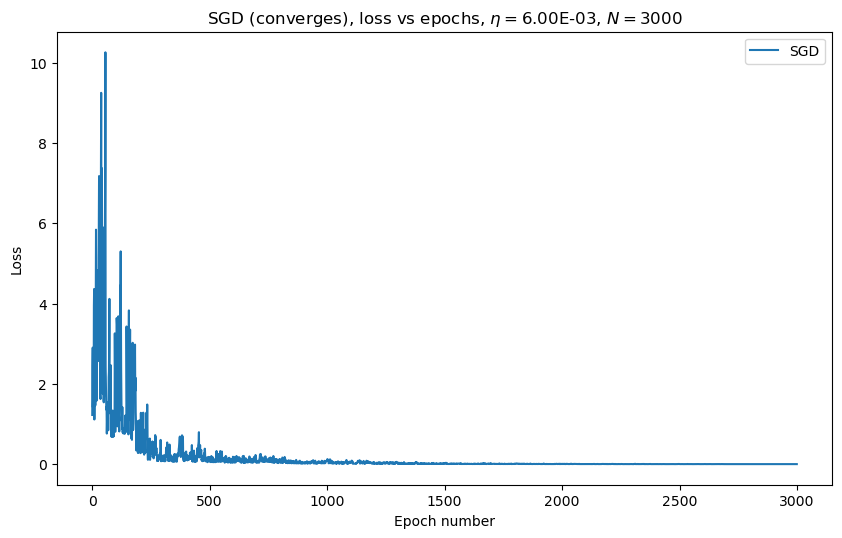

  0%|          | 0/3000 [00:00<?, ?it/s]

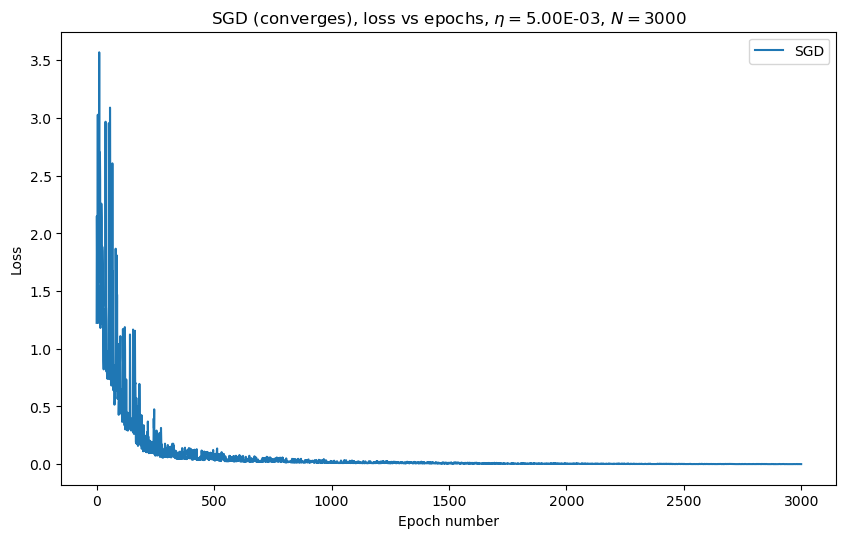

  0%|          | 0/3000 [00:00<?, ?it/s]

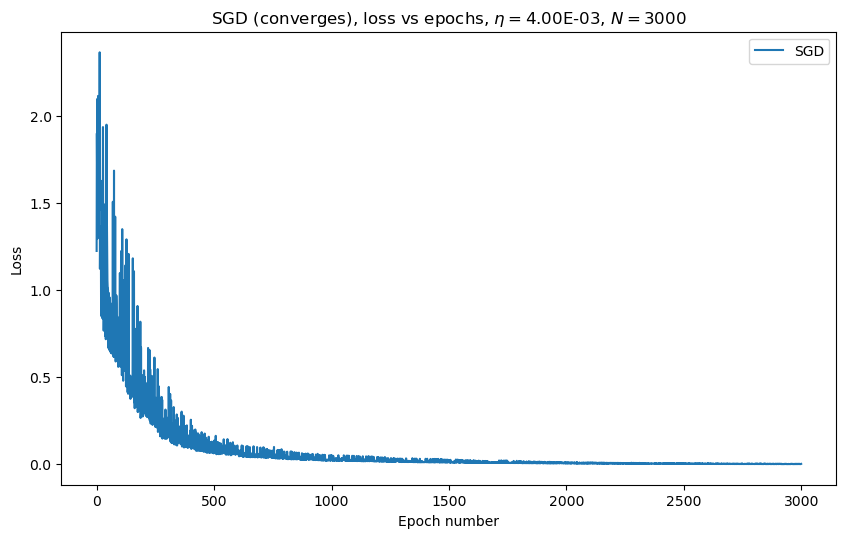

  0%|          | 0/3000 [00:00<?, ?it/s]

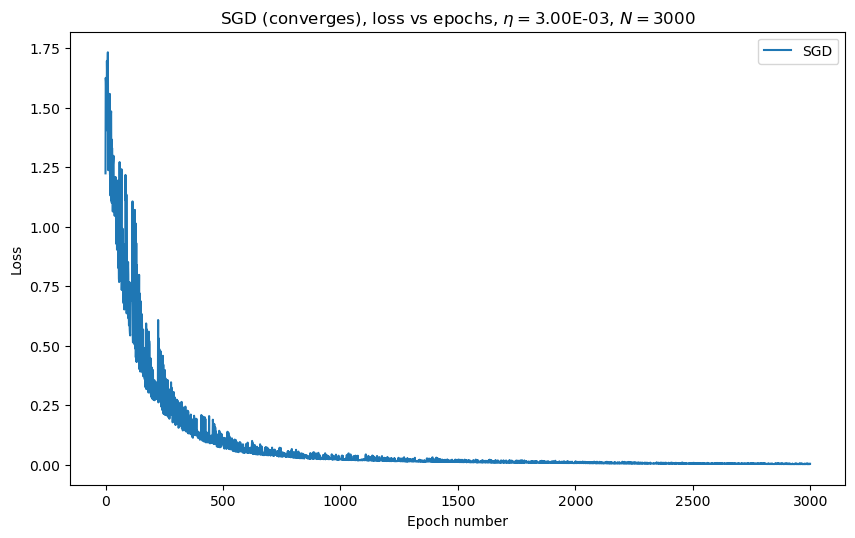

  0%|          | 0/3000 [00:00<?, ?it/s]

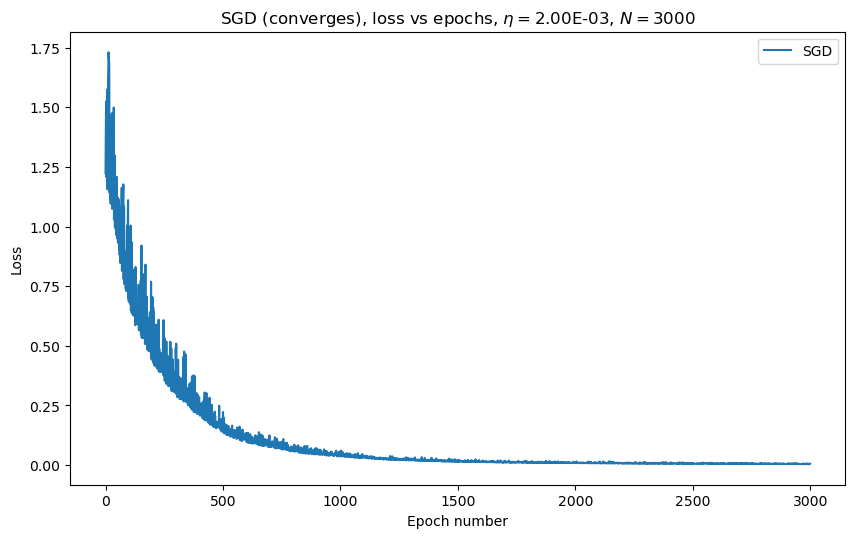

  0%|          | 0/3000 [00:00<?, ?it/s]

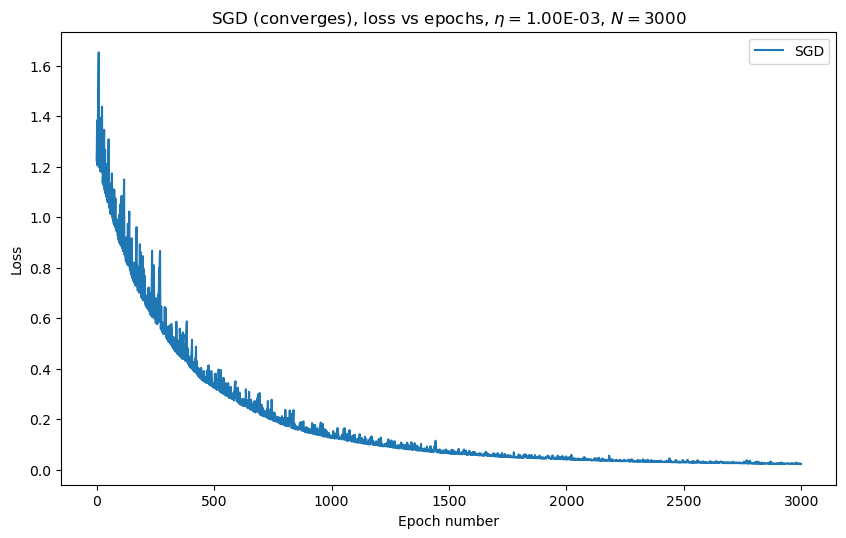

In [21]:
# SGD LR grid check

learning_rates_array = np.linspace(
    10**-2, 10**-3, 10
)  # np.geomspace(10**-3, 10**-2, num=10)
ITERATIONS = 3000
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1

converging_learning_rates_sgd = np.array([])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, LEARNING_RATE in enumerate(learning_rates_array):
        (
            recorded_sgd_weights,
            recorded_sgd_cost_values,
            recorded_sgd_iteration_times,
        ) = lls_sgd_train(train, train_labels, LEARNING_RATE, ITERATIONS)

        sgd_converging_bool = convergence_approach_test(recorded_sgd_cost_values)

        if sgd_converging_bool:
            sgd_converging_str = "converges"
            converging_learning_rates_sgd = np.append(
                converging_learning_rates_sgd, LEARNING_RATE
            )
        else:
            sgd_converging_str = "diverges"

        fig = plt.figure(figsize=(10, 6), dpi=100)
        ax1 = plt.subplot(111)
        ax1.plot(np.arange(0, ITERATIONS, 1), recorded_sgd_cost_values, label="SGD")

        ax1.set_title(
            "SGD ("
            + sgd_converging_str
            + r"), loss vs epochs, $\eta=$"
            + "{:.2E}".format(LEARNING_RATE)
            + r", $N=$"
            + str(ITERATIONS)
        )
        ax1.set_xlabel(r"Epoch number")
        ax1.set_ylabel(r"Loss")
        ax1.legend(loc="best")
        plt.show()
FASTEST_LEARNING_RATE_SGD = np.max(converging_learning_rates_sgd)



In [22]:
print(
    "The fastest learning rate that converges for a given dataset for GD is ",
    FASTEST_LEARNING_RATE_GD,
)

print(
    "The minimum learning rate that converges for a given dataset for SGD is ",
    FASTEST_LEARNING_RATE_SGD,
)

The fastest learning rate that converges for a given dataset for GD is  0.001
The minimum learning rate that converges for a given dataset for SGD is  0.006


Hence, we've found that we can't improve the learning rate for GD, and we'll proceed with 0.001.
As for SGD, the largest learning rate that still makes sure the loss is converge is 0.06.
Now we'll be able to evaluate the performance of both algorithms more fairly. At this point, we'll run the code for a larger amount of iterations, because we really want to check that our model has found a minimum that it won't jump out from and the testing accuracy has reached a final value with the same randomised dataset:

  0%|          | 0/2000 [00:00<?, ?it/s]

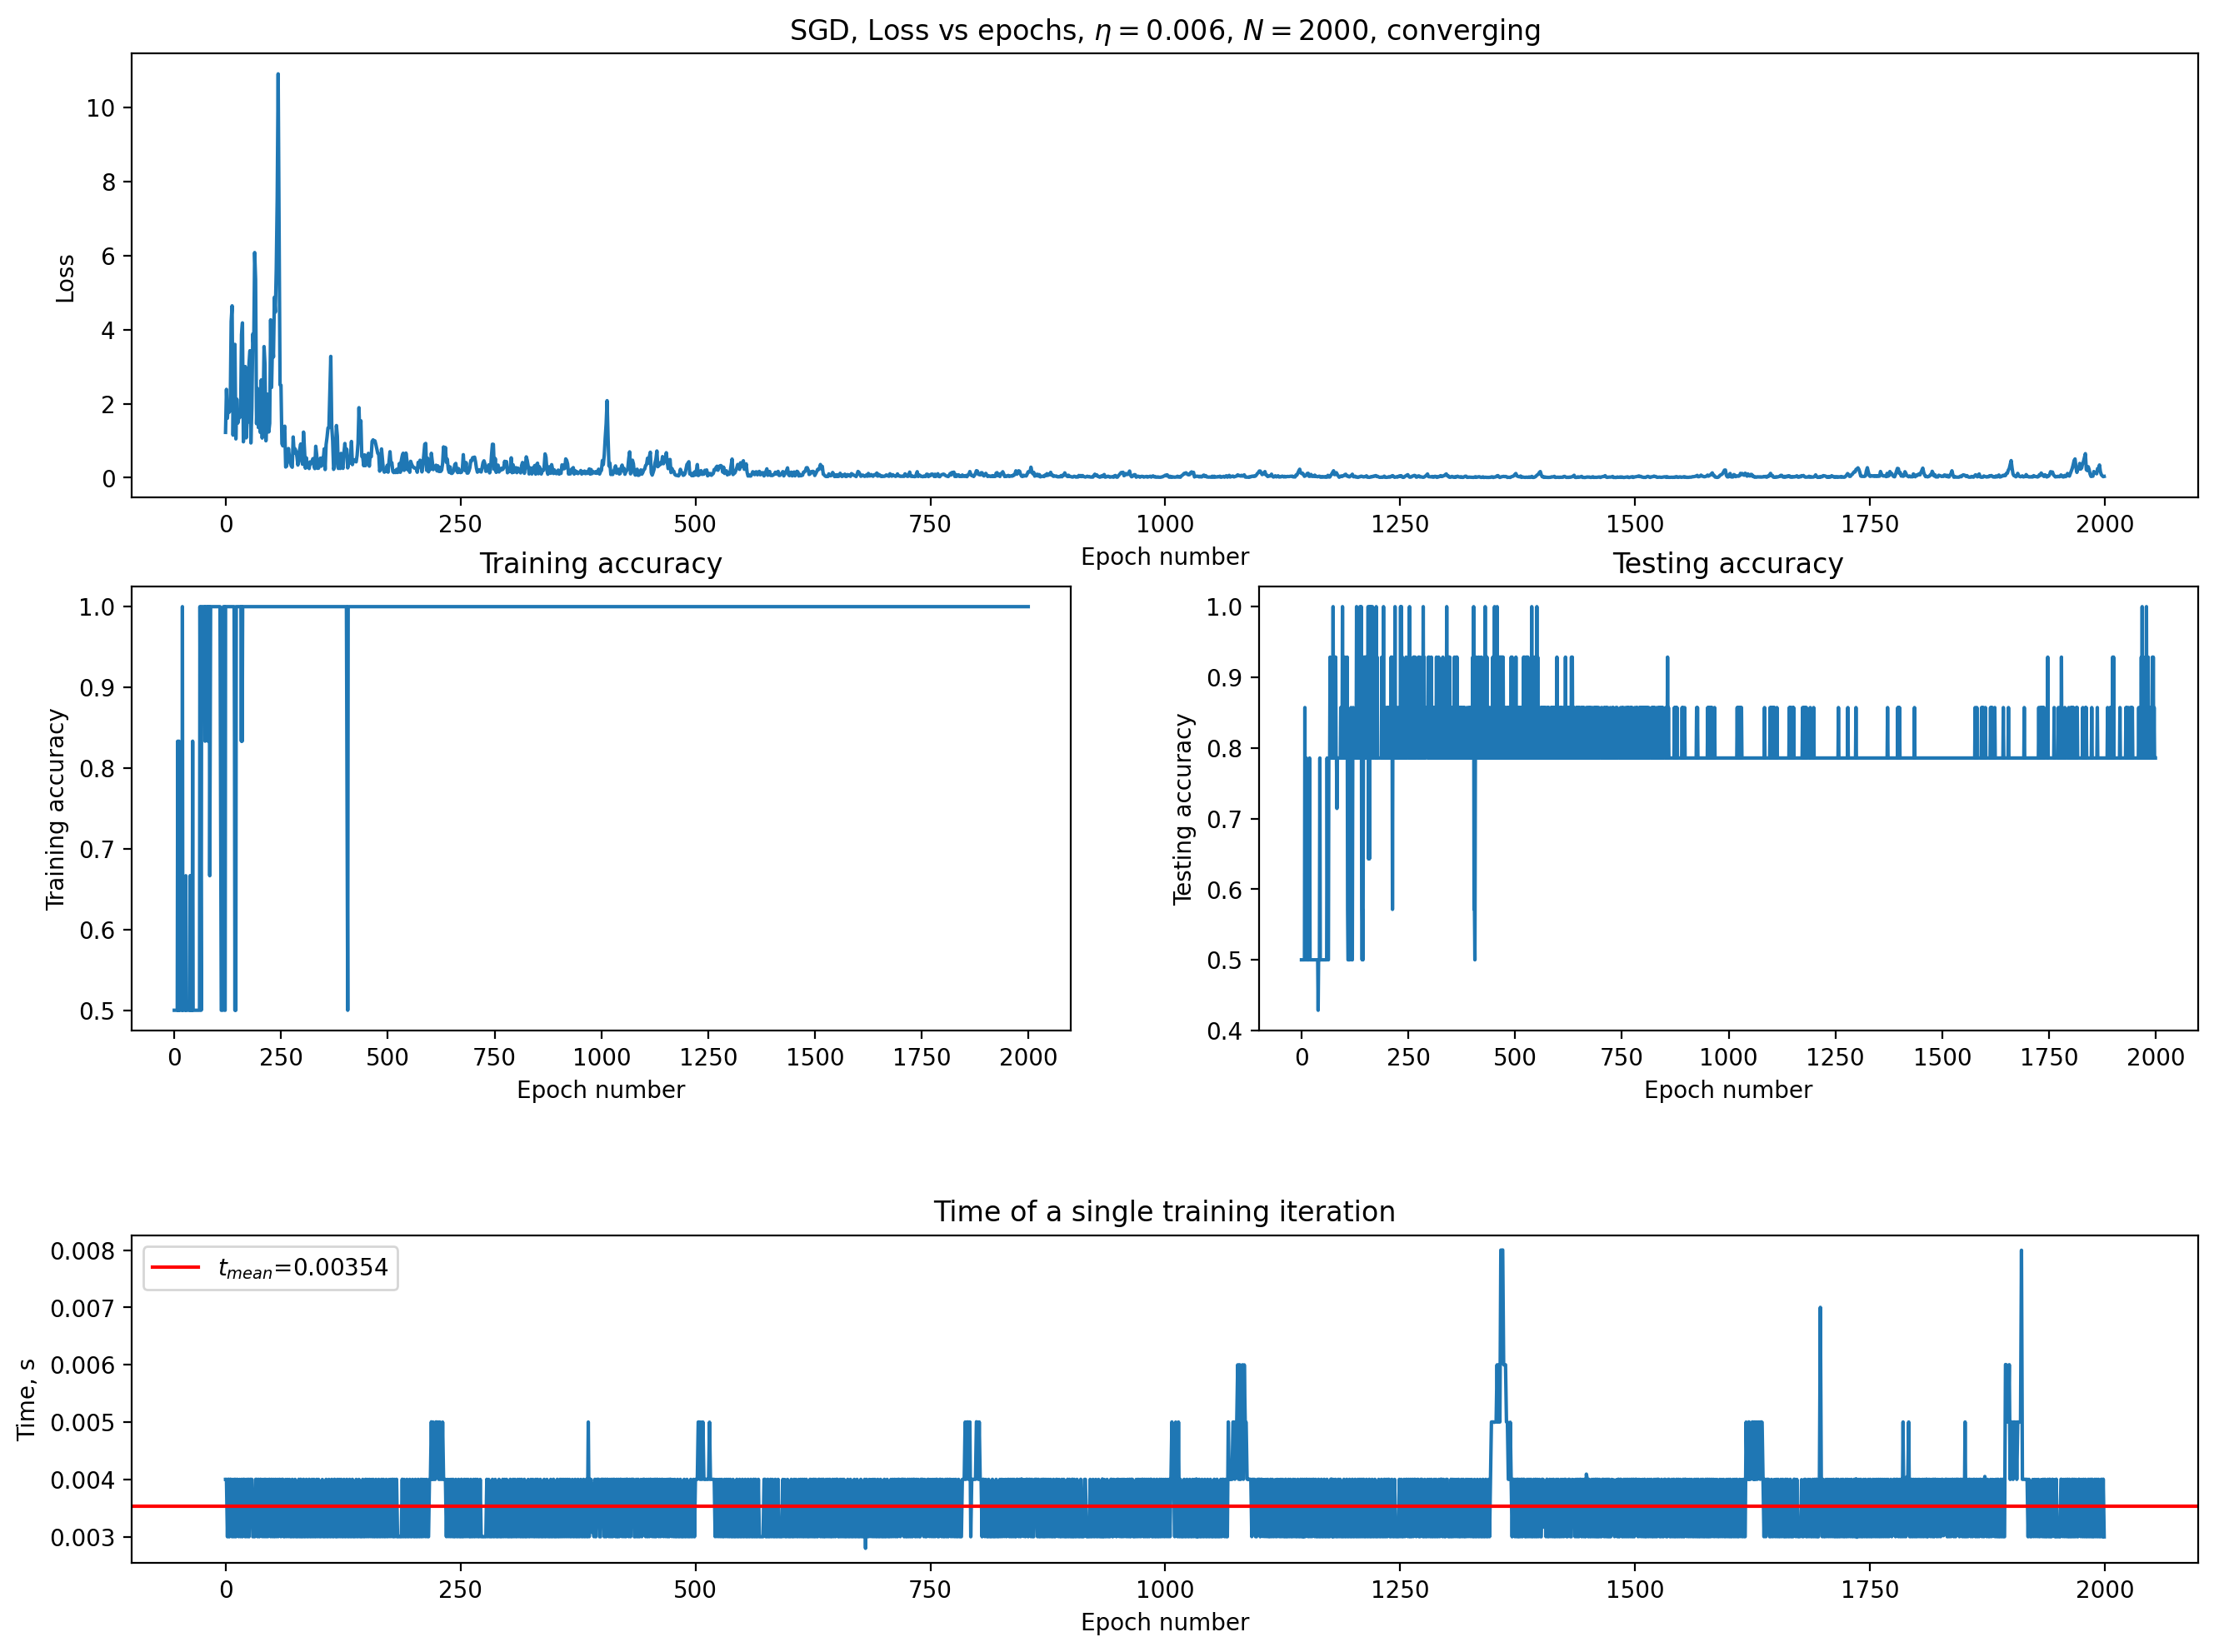

In [23]:
LEARNING_RATE = FASTEST_LEARNING_RATE_SGD
ITERATIONS = 2000
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1


exp_data, exp_labels = split_and_relabel_dataset(
    full_data=data,
    full_labels=labels,
    original_subject_labels=ORIGINAL_SUBJECT_LABELS,
    labels_to_set=LABELS_TO_SET,
)
train, train_labels, test, test_labels = train_test_random_split(
    experiment_data=exp_data, experiment_labels=exp_labels, number_per_class_train=3
)


recorded_sgd_weights, recorded_sgd_cost_values, recorded_sgd_iteration_times = lls_sgd_train(
    train, train_labels, LEARNING_RATE, ITERATIONS
)
converging_or_not_sgd = convergence_approach_test(recorded_sgd_cost_values)
train_sgd_accuracies = from_recorded_weights_to_accuracy_array(
    train, train_labels, recorded_sgd_weights, Y_1, Y_2, ITERATIONS
)
test_sgd_accuracies = from_recorded_weights_to_accuracy_array(
    test, test_labels, recorded_sgd_weights, Y_1, Y_2, ITERATIONS
)

plot_results(
    "SGD",
    converging_or_not_sgd,
    recorded_sgd_cost_values,
    train_sgd_accuracies,
    test_sgd_accuracies,
    recorded_sgd_iteration_times,
    LEARNING_RATE,
    ITERATIONS,
)


  0%|          | 0/2000 [00:00<?, ?it/s]

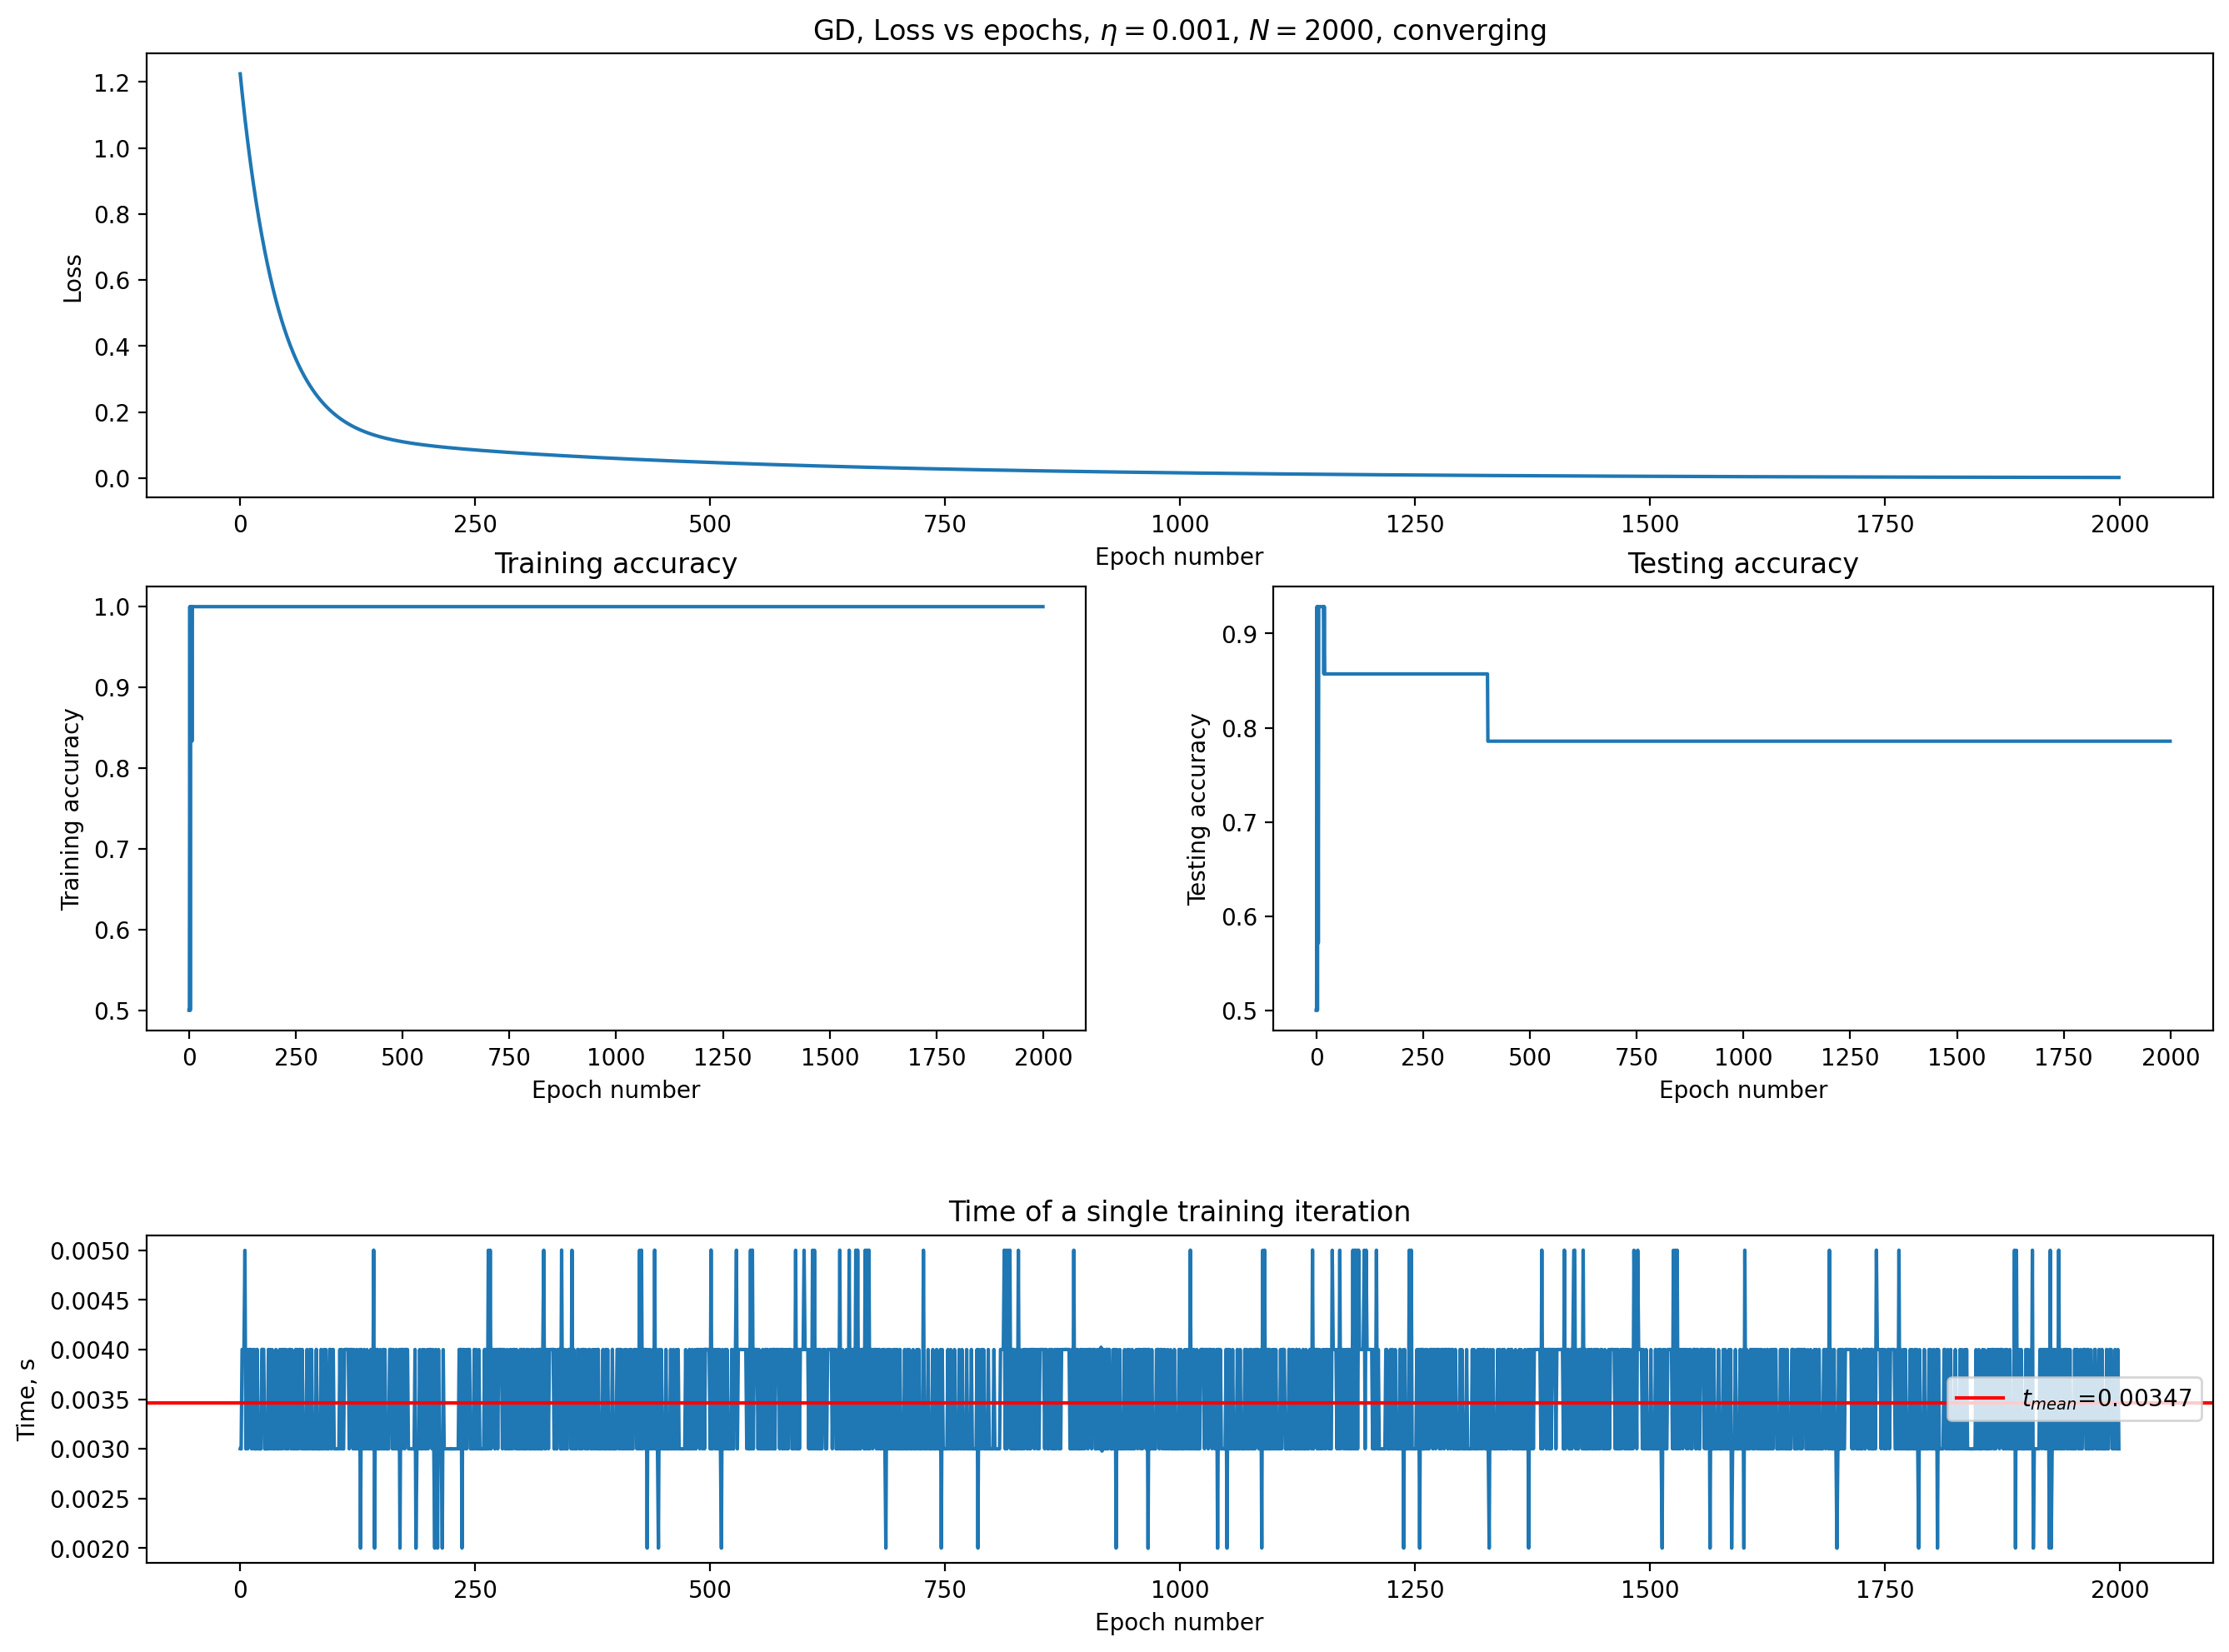

In [24]:
LEARNING_RATE = FASTEST_LEARNING_RATE_GD
ITERATIONS = 2000
ORIGINAL_SUBJECT_LABELS = np.array([1, 30])
LABELS_TO_SET = np.array([-1, 1])
Y_1 = -1
Y_2 = 1

recorded_gd_weights, recorded_gd_cost_values, recorded_gd_iteration_times = lls_gd_train(
    train, train_labels, LEARNING_RATE, ITERATIONS
)
converging_or_not_gd = convergence_approach_test(recorded_gd_cost_values)
train_gd_accuracies = from_recorded_weights_to_accuracy_array(
    train, train_labels, recorded_gd_weights, Y_1, Y_2, ITERATIONS
)
test_gd_accuracies = from_recorded_weights_to_accuracy_array(
    test, test_labels, recorded_gd_weights, Y_1, Y_2, ITERATIONS
)

plot_results(
    "GD",
    converging_or_not_gd,
    recorded_gd_cost_values,
    train_gd_accuracies,
    test_gd_accuracies,
    recorded_gd_iteration_times,
    LEARNING_RATE,
    ITERATIONS,
)


Finally, with the best chosen rates, we proceed to fully evaluate the performance of both algorithms. We consider the following metrics:
Due to the fact that we run the code with the same large number of iterations, and GD is a priori much faster to reduce the loss IN TERMS OF ITERATIONS and will have a smaller value of loss at the end of the loop, we want to look at the time that GD took to reach the smallest value that SGD got, and compare it to the time that SGD took to get to the same value. Most of the time GD will win, unless SGD's stochastic nature managed to get it to a few very low points - that's why we've got that if in the cell. If, while checking, you get the "GD did not reach SGD's minimum loss value." printout, I suggest that you rerun the previous two cells.
We look at the time that GD and SGD took to settle on their train and test result accuracies - GD will always win.
Finally, we compare train and test losses that the models settled on. SGD is much more likely to achieve both train and test accuracies under 100%. The reasons are explained in more depth in the report.

In [25]:
print(
    r"With fastest GD η =",
    str(FASTEST_LEARNING_RATE_GD),
    r"and fastest SGD η =",
    str(FASTEST_LEARNING_RATE_SGD),
    ":\n",
)

index_where_gd_loss_becomes_smaller_than_minimum_sgd_loss = np.where(
    recorded_gd_cost_values < np.min(recorded_sgd_cost_values)
)[0]


if index_where_gd_loss_becomes_smaller_than_minimum_sgd_loss.size == 0:
    print("GD did not reach SGD's minimum loss value.")
else:
    index_where_gd_loss_becomes_smaller_than_minimum_sgd_loss = (
        index_where_gd_loss_becomes_smaller_than_minimum_sgd_loss[0]
    )
    time_taken_for_gd_to_reach_sgds_minimum_loss = np.sum(
        recorded_gd_iteration_times[
            :index_where_gd_loss_becomes_smaller_than_minimum_sgd_loss
        ]
    )
    index_where_sgd_loss_becomes_smallest = np.argmin(recorded_sgd_cost_values)
    time_taken_for_sgd_to_reach_its_minimum_loss = np.sum(
        recorded_sgd_iteration_times[:index_where_sgd_loss_becomes_smallest]
    )
    print(
        "Time taken for GD to reach SGD'S smallest loss:",
        str(time_taken_for_gd_to_reach_sgds_minimum_loss),
        "s\nTime taken for SGD to reach it's minimum loss:",
        str(time_taken_for_sgd_to_reach_its_minimum_loss),
        "s",
    )
index_where_gd_train_accuracy_settles = find_index_of_last_change(train_gd_accuracies)
index_where_gd_test_accuracy_settles = find_index_of_last_change(test_gd_accuracies)

index_where_sgd_train_accuracy_settles = find_index_of_last_change(train_sgd_accuracies)
index_where_sgd_test_accuracy_settles = find_index_of_last_change(test_sgd_accuracies)

time_taken_for_gd_train_accuracy_to_settle = np.sum(
    recorded_gd_iteration_times[:index_where_gd_train_accuracy_settles]
)
time_taken_for_gd_test_accuracy_to_settle = np.sum(
    recorded_gd_iteration_times[:index_where_gd_test_accuracy_settles]
)

time_taken_for_sgd_train_accuracy_to_settle = np.sum(
    recorded_sgd_iteration_times[:index_where_sgd_train_accuracy_settles]
)
time_taken_for_sgd_test_accuracy_to_settle = np.sum(
    recorded_sgd_iteration_times[:index_where_sgd_test_accuracy_settles]
)

print(
    "Time taken for GD's train accuracy to settle:",
    str(time_taken_for_gd_train_accuracy_to_settle),
    "s\nTime taken for SGD's train accuracy to settle:",
    str(time_taken_for_sgd_train_accuracy_to_settle),
)
print(
    "Time taken for GD's test accuracy to settle:",
    str(time_taken_for_gd_test_accuracy_to_settle),
    "s\nTime taken for SGD's test accuracy to settle:",
    str(time_taken_for_sgd_test_accuracy_to_settle),
)
print(
    "Final GD train accuracy for this take is",
    str(train_gd_accuracies[-1]),
    ". Final SGD train accuracy for this take is",
    str(train_sgd_accuracies[-1]),
)
print(
    "Final GD test accuracy for this take is",
    str(test_gd_accuracies[-1]),
    ". Final SGD test accuracy for this take is",
    str(test_sgd_accuracies[-1]),
)


With fastest GD η = 0.001 and fastest SGD η = 0.006 :

Time taken for GD to reach SGD'S smallest loss: 5.141152858734131 s
Time taken for SGD to reach it's minimum loss: 5.089138984680176 s
Time taken for GD's train accuracy to settle: 0.030005216598510742 s
Time taken for SGD's train accuracy to settle: 1.404317855834961
Time taken for GD's test accuracy to settle: 1.3743095397949219 s
Time taken for SGD's test accuracy to settle: 7.062983989715576
Final GD train accuracy for this take is 1.0 . Final SGD train accuracy for this take is 1.0
Final GD test accuracy for this take is 0.7857142857142857 . Final SGD test accuracy for this take is 0.7857142857142857


#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.